In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, coint
import matplotlib.pyplot as plt
import seaborn as sns
from hurst import compute_Hc
from pykalman import KalmanFilter 
from itertools import combinations
from pykalman import KalmanFilter
import warnings

plt.style.use('seaborn-v0_8-darkgrid')
warnings.filterwarnings('ignore')

In [10]:
start_date = "2024-01-01"
end_date = "2025-01-01"

coins = [
    "BTC-USD","ETH-USD","USDT-USD","XRP-USD","BNB-USD","SOL-USD","USDC-USD","DOGE-USD","TRX-USD","ADA-USD",
    "HYPE-USD","SUI-USD","LINK-USD","LEO-USD","AVAX-USD","XLM-USD","BCH-USD","TON-USD","SHIB-USD","HBAR-USD",
    "LTC-USD","DOT-USD","XMR-USD","USDE-USD","BGB-USD","DAI-USD","PEPE-USD","PI-USD","UNI-USD","AAVE-USD",
    "TAO-USD","APT-USD","OKB-USD","CRO-USD","NEAR-USD","ICP-USD","ETC-USD","ONDO-USD","GT-USD","KAS-USD",
    "POL-USD","MNT-USD","USD1-USD","TRUMP-USD","VET-USD","RUNE-USD","FLOW-USD","TONCOIN-USD","XEC-USD","APE-USD",
    "MATIC-USD","MKR-USD","AXS-USD","ZEC-USD","XTZ-USD","FIL-USD","MANA-USD","IMX-USD","KLAY-USD","DYDX-USD",
    "OMG-USD","EOS-USD","ATOM-USD","CHZ-USD","MASK-USD","CQT-USD","LDO-USD","FRONT-USD","CBETH-USD","PEOPLE-USD",
    "KDA-USD","LBR-USD","ERGO-USD","CHSB-USD","RPL-USD","WLD-USD","LPT-USD","GLM-USD","MINA-USD","KSM-USD",
    "HBTC-USD","AR-USD","ENS-USD","SAND-USD","ENJ-USD","OP-USD","RIF-USD","TUSD-USD","PAX-USD","USDJ-USD"
]

In [11]:
crypto_data_4h = {}

print(f"Fetching coins data from {start_date} to {end_date}...\n")

for coin in coins:
    try:
        data = yf.download(coin, start=start_date, end=end_date, interval='1h', progress=False)
        if not data.empty:
            data_4h = data['Close'].resample('4H').first().ffill()
            crypto_data_4h[coin] = data_4h.dropna()
            print(f"Successfully fetched and resampled data for {coin}")
        else:
            print(f"No data found for {coin} with 1h interval.")
    except Exception as e:
        print(f"Could not fetch data for {coin}: {e}")

print(f"\nFetched data for {len(crypto_data_4h)} cryptos.")

if crypto_data_4h:
    sample_ticker = list(crypto_data_4h.keys())[0]
    print(f"\nSample data for {sample_ticker} (first 5 rows):")
    print(crypto_data_4h[sample_ticker].head())

def adf_test(series, significance_level=0.05):
    result = adfuller(series.dropna())
    p_value = result[1]
    adf_statistic = result[0]
    critical_values = result[4]

    is_stationary_p_value = p_value < significance_level
    is_stationary_statistic = adf_statistic < critical_values['5%'] 

    return p_value, is_stationary_p_value, adf_statistic, critical_values, is_stationary_statistic

Fetching coins data from 2024-01-01 to 2025-01-01...

Successfully fetched and resampled data for BTC-USD
Successfully fetched and resampled data for ETH-USD
Successfully fetched and resampled data for USDT-USD
Successfully fetched and resampled data for XRP-USD
Successfully fetched and resampled data for BNB-USD
Successfully fetched and resampled data for SOL-USD
Successfully fetched and resampled data for USDC-USD
Successfully fetched and resampled data for DOGE-USD
Successfully fetched and resampled data for TRX-USD
Successfully fetched and resampled data for ADA-USD
Successfully fetched and resampled data for HYPE-USD
Successfully fetched and resampled data for SUI-USD
Successfully fetched and resampled data for LINK-USD
Successfully fetched and resampled data for LEO-USD
Successfully fetched and resampled data for AVAX-USD
Successfully fetched and resampled data for XLM-USD
Successfully fetched and resampled data for BCH-USD
Successfully fetched and resampled data for TON-USD



1 Failed download:
['SHIB-USD']: Timeout('Failed to perform, curl: (28) Operation timed out after 10002 milliseconds with 133635 bytes received. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.')


No data found for SHIB-USD with 1h interval.
Successfully fetched and resampled data for HBAR-USD
Successfully fetched and resampled data for LTC-USD
Successfully fetched and resampled data for DOT-USD
Successfully fetched and resampled data for XMR-USD
Successfully fetched and resampled data for USDE-USD
Successfully fetched and resampled data for BGB-USD
Successfully fetched and resampled data for DAI-USD



1 Failed download:
['PEPE-USD']: YFPricesMissingError('possibly delisted; no price data found  (1h 2024-01-01 -> 2025-01-01)')


No data found for PEPE-USD with 1h interval.
Successfully fetched and resampled data for PI-USD
Successfully fetched and resampled data for UNI-USD
Successfully fetched and resampled data for AAVE-USD



1 Failed download:
['TAO-USD']: YFPricesMissingError('possibly delisted; no price data found  (1h 2024-01-01 -> 2025-01-01)')


No data found for TAO-USD with 1h interval.
Successfully fetched and resampled data for APT-USD
Successfully fetched and resampled data for OKB-USD
Successfully fetched and resampled data for CRO-USD
Successfully fetched and resampled data for NEAR-USD
Successfully fetched and resampled data for ICP-USD
Successfully fetched and resampled data for ETC-USD
Successfully fetched and resampled data for ONDO-USD
Successfully fetched and resampled data for GT-USD
Successfully fetched and resampled data for KAS-USD



1 Failed download:
['POL-USD']: YFPricesMissingError('possibly delisted; no price data found  (1h 2024-01-01 -> 2025-01-01)')


No data found for POL-USD with 1h interval.
Successfully fetched and resampled data for MNT-USD



1 Failed download:
['USD1-USD']: YFPricesMissingError('possibly delisted; no price data found  (1h 2024-01-01 -> 2025-01-01) (Yahoo error = "Data doesn\'t exist for startDate = 1704067200, endDate = 1735689600")')


No data found for USD1-USD with 1h interval.
Successfully fetched and resampled data for TRUMP-USD
Successfully fetched and resampled data for VET-USD
Successfully fetched and resampled data for RUNE-USD
Successfully fetched and resampled data for FLOW-USD



1 Failed download:
['TONCOIN-USD']: YFPricesMissingError('possibly delisted; no price data found  (1h 2024-01-01 -> 2025-01-01)')


No data found for TONCOIN-USD with 1h interval.
Successfully fetched and resampled data for XEC-USD
Successfully fetched and resampled data for APE-USD
Successfully fetched and resampled data for MATIC-USD
Successfully fetched and resampled data for MKR-USD
Successfully fetched and resampled data for AXS-USD
Successfully fetched and resampled data for ZEC-USD
Successfully fetched and resampled data for XTZ-USD
Successfully fetched and resampled data for FIL-USD
Successfully fetched and resampled data for MANA-USD



1 Failed download:
['IMX-USD']: YFPricesMissingError('possibly delisted; no price data found  (1h 2024-01-01 -> 2025-01-01)')


No data found for IMX-USD with 1h interval.
Successfully fetched and resampled data for KLAY-USD
Successfully fetched and resampled data for DYDX-USD
Successfully fetched and resampled data for OMG-USD
Successfully fetched and resampled data for EOS-USD
Successfully fetched and resampled data for ATOM-USD
Successfully fetched and resampled data for CHZ-USD



1 Failed download:
['MASK-USD']: YFPricesMissingError('possibly delisted; no price data found  (1h 2024-01-01 -> 2025-01-01)')


No data found for MASK-USD with 1h interval.
Successfully fetched and resampled data for CQT-USD
Successfully fetched and resampled data for LDO-USD
Successfully fetched and resampled data for FRONT-USD
Successfully fetched and resampled data for CBETH-USD
Successfully fetched and resampled data for PEOPLE-USD
Successfully fetched and resampled data for KDA-USD



1 Failed download:
['LBR-USD']: YFPricesMissingError('possibly delisted; no price data found  (1h 2024-01-01 -> 2025-01-01)')


No data found for LBR-USD with 1h interval.



1 Failed download:
['ERGO-USD']: YFTzMissingError('possibly delisted; no timezone found')


No data found for ERGO-USD with 1h interval.



1 Failed download:
['CHSB-USD']: YFPricesMissingError('possibly delisted; no price data found  (1h 2024-01-01 -> 2025-01-01)')


No data found for CHSB-USD with 1h interval.
Successfully fetched and resampled data for RPL-USD
Successfully fetched and resampled data for WLD-USD
Successfully fetched and resampled data for LPT-USD
Successfully fetched and resampled data for GLM-USD
Successfully fetched and resampled data for MINA-USD
Successfully fetched and resampled data for KSM-USD
Successfully fetched and resampled data for HBTC-USD
Successfully fetched and resampled data for AR-USD
Successfully fetched and resampled data for ENS-USD
Successfully fetched and resampled data for SAND-USD
Successfully fetched and resampled data for ENJ-USD
Successfully fetched and resampled data for OP-USD
Successfully fetched and resampled data for RIF-USD
Successfully fetched and resampled data for TUSD-USD



1 Failed download:
['PAX-USD']: YFTzMissingError('possibly delisted; no timezone found')


No data found for PAX-USD with 1h interval.
Successfully fetched and resampled data for USDJ-USD

Fetched data for 78 cryptos.

Sample data for BTC-USD (first 5 rows):
Ticker                          BTC-USD
Datetime                               
2024-01-01 00:00:00+00:00  42477.253906
2024-01-01 04:00:00+00:00  42387.164062
2024-01-01 08:00:00+00:00  42546.414062
2024-01-01 12:00:00+00:00  42664.109375
2024-01-01 16:00:00+00:00  42727.890625



Performing ADF Test for stationarity (target p-value < 0.05):
BTC-USD: p-value=0.7884, ADF Stat=-0.90, 5% Crit Val=-2.86
ETH-USD: p-value=0.2209, ADF Stat=-2.16, 5% Crit Val=-2.86
USDT-USD: p-value=0.0001, ADF Stat=-4.60, 5% Crit Val=-2.86
  -> USDT-USD is stationary based on p-value (0.0001 < 0.05)
  -> USDT-USD is stationary based on test statistic (-4.60 < -2.86)
XRP-USD: p-value=0.9777, ADF Stat=0.31, 5% Crit Val=-2.86
BNB-USD: p-value=0.3848, ADF Stat=-1.79, 5% Crit Val=-2.86
SOL-USD: p-value=0.3606, ADF Stat=-1.84, 5% Crit Val=-2.86
USDC-USD: p-value=0.0000, ADF Stat=-6.04, 5% Crit Val=-2.86
  -> USDC-USD is stationary based on p-value (0.0000 < 0.05)
  -> USDC-USD is stationary based on test statistic (-6.04 < -2.86)
DOGE-USD: p-value=0.7532, ADF Stat=-1.00, 5% Crit Val=-2.86
TRX-USD: p-value=0.8345, ADF Stat=-0.75, 5% Crit Val=-2.86
ADA-USD: p-value=0.8231, ADF Stat=-0.79, 5% Crit Val=-2.86
HYPE-USD: p-value=0.2192, ADF Stat=-2.16, 5% Crit Val=-2.86
SUI-USD: p-value=0.0501, AD

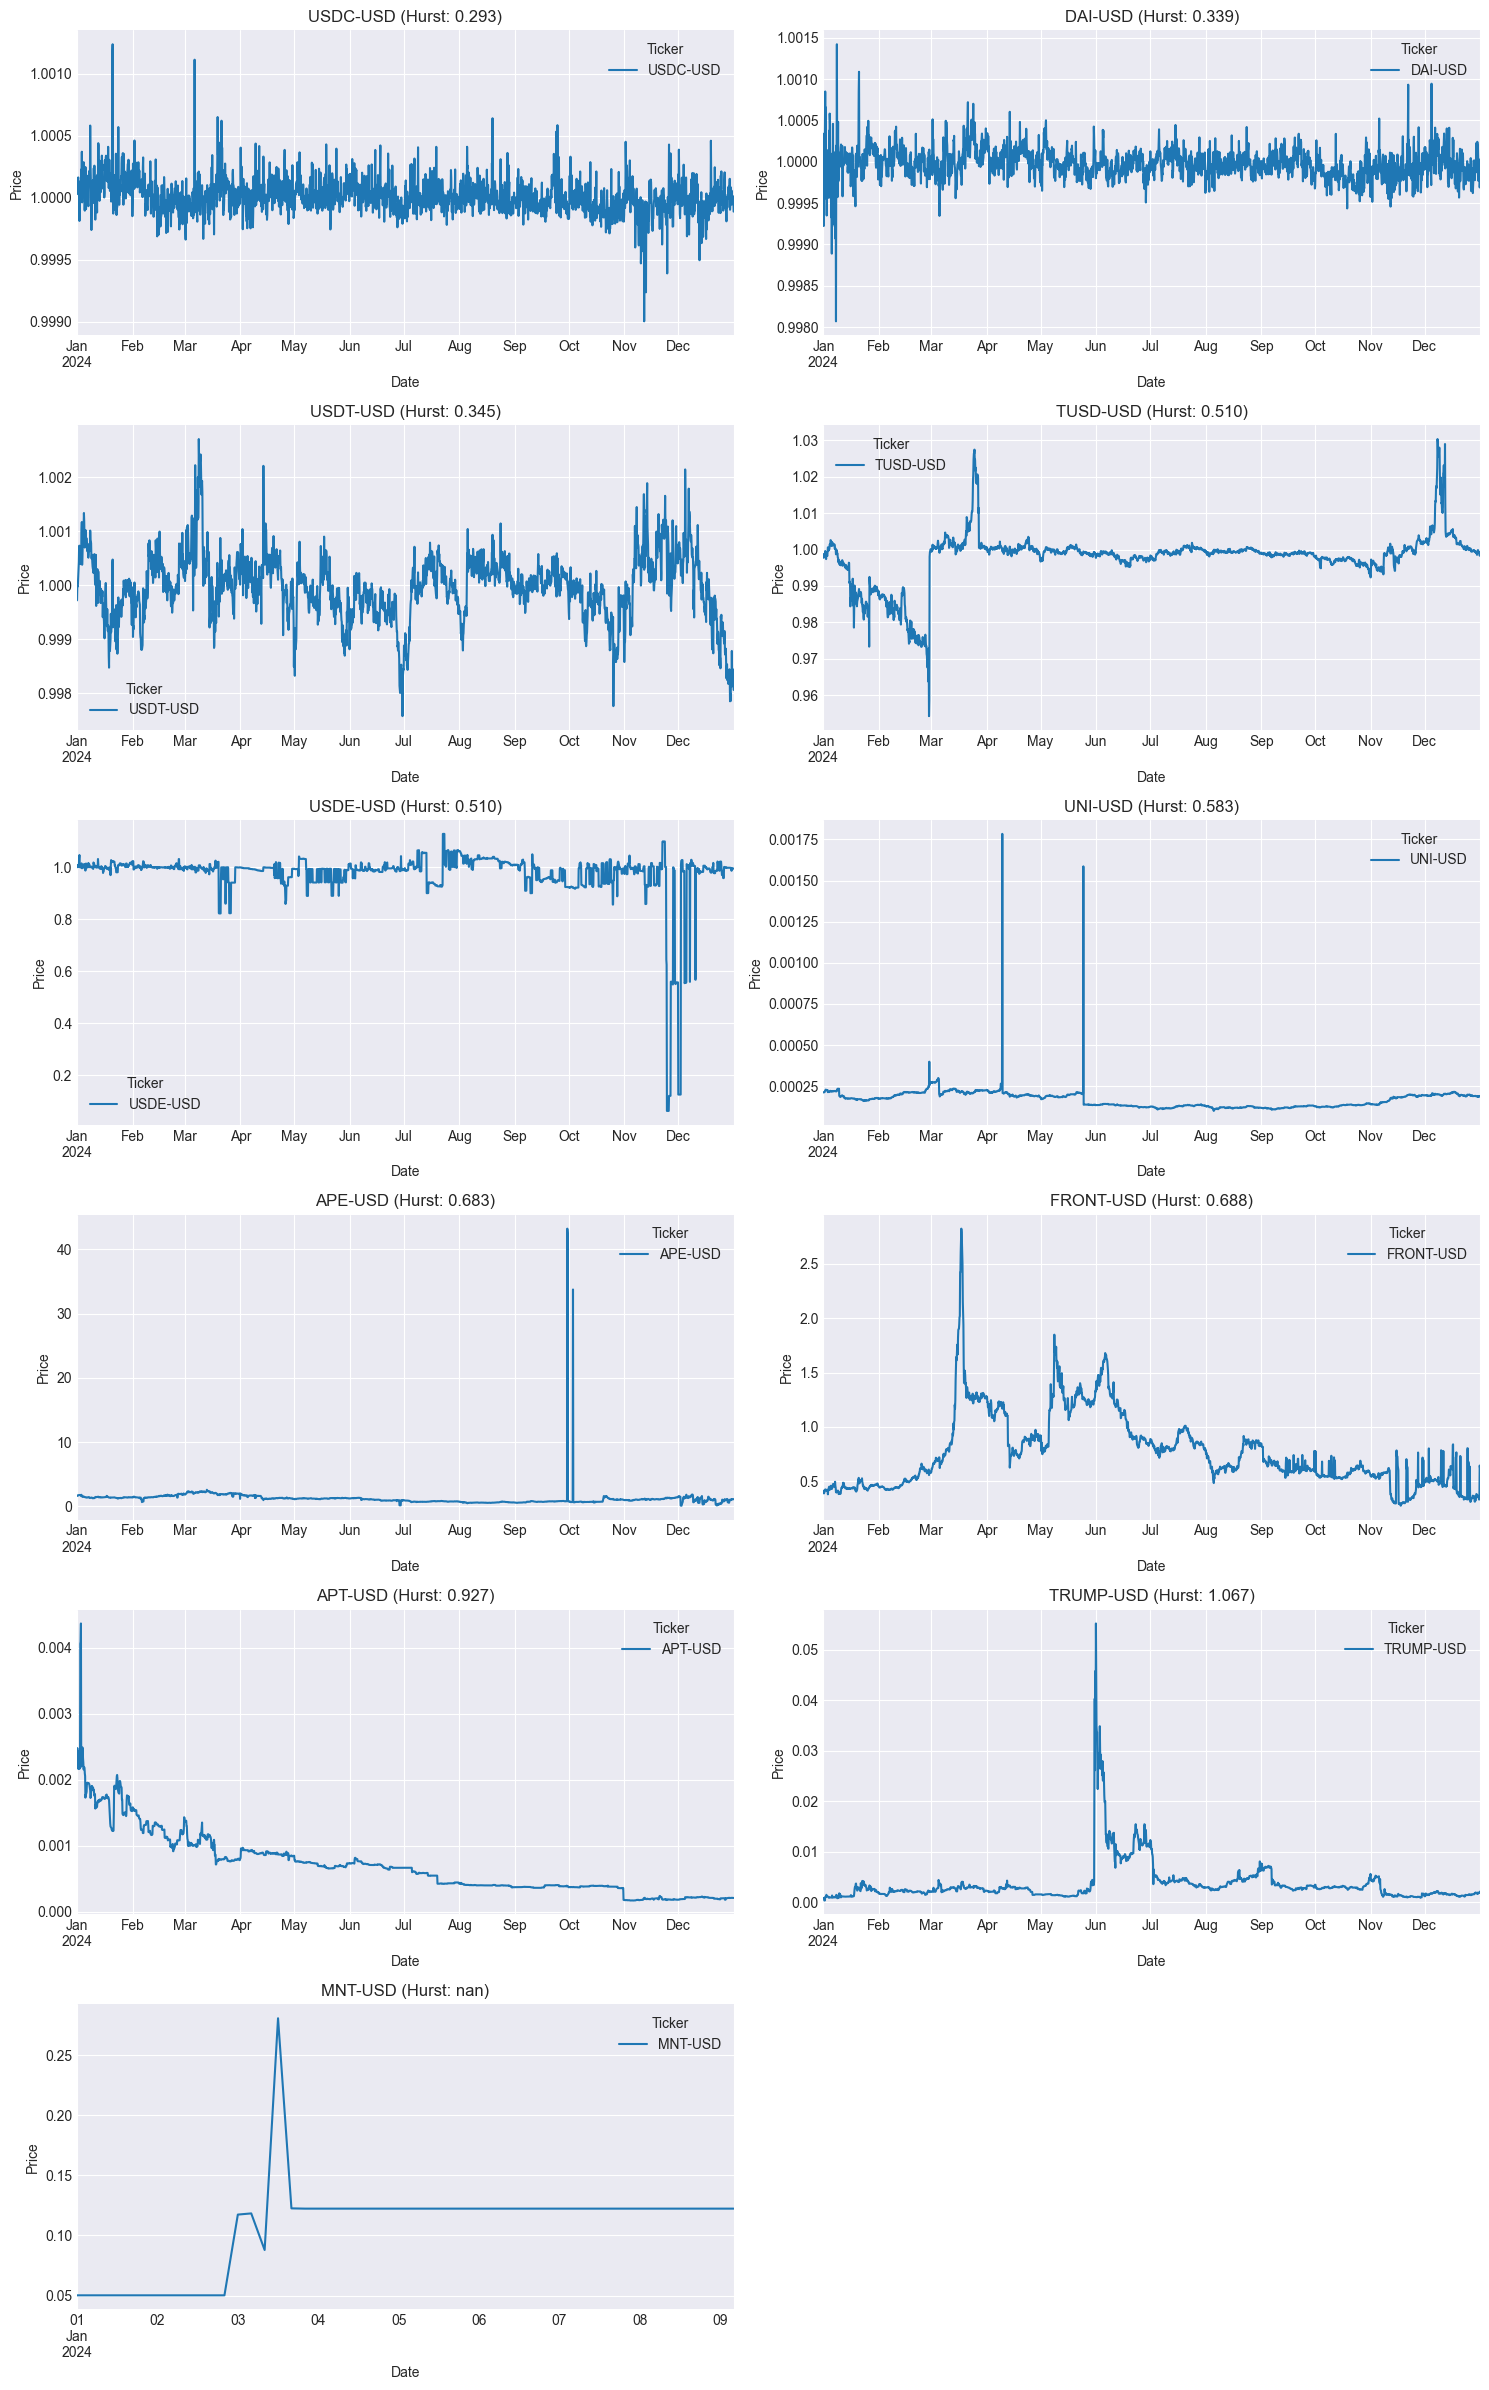

In [12]:
stationary_cryptos_p_value = {}
stationary_cryptos_statistic = {}
adf_results_all = {}

print("\nPerforming ADF Test for stationarity (target p-value < 0.05):")
for ticker, price_series in crypto_data_4h.items():
    if len(price_series) > 20: 
        p_val, is_stat_pval, adf_stat, crit_vals, is_stat_stat = adf_test(price_series)
        adf_results_all[ticker] = {'p_value': p_val, 'adf_statistic': adf_stat, 'critical_values': crit_vals}
        print(f"{ticker}: p-value={p_val:.4f}, ADF Stat={adf_stat:.2f}, 5% Crit Val={crit_vals['5%']:.2f}")

        if is_stat_pval:
            stationary_cryptos_p_value[ticker] = p_val
            print(f"  -> {ticker} is stationary based on p-value ({p_val:.4f} < 0.05)")
        if is_stat_stat:
            stationary_cryptos_statistic[ticker] = {'adf_statistic': adf_stat, '5_crit_val': crit_vals['5%']}
            print(f"  -> {ticker} is stationary based on test statistic ({adf_stat:.2f} < {crit_vals['5%']:.2f})")
    else:
        print(f"Skipping ADF test for {ticker} due to insufficient data points ({len(price_series)}).")

print("\n--- Stationarity Test Results ---")

print("\nMethod 1: Stationary Cryptos (based on p-value < 0.05):")
if stationary_cryptos_p_value:
    for ticker, p_val in sorted(stationary_cryptos_p_value.items(), key=lambda item: item[1]):
        print(f"- {ticker}: p-value = {p_val:.4f}")
else:
    print("No stationary cryptocurrencies found using the p-value method.")

print("\nMethod 2: Stationary Cryptos (based on ADF Statistic < 5% Critical Value):")
if stationary_cryptos_statistic:
    for ticker, stat_info in stationary_cryptos_statistic.items():
        print(f"- {ticker}: ADF Stat = {stat_info['adf_statistic']:.2f}, 5% Crit = {stat_info['5_crit_val']:.2f}")
else:
    print("No stationary cryptocurrencies found using the ADF statistic method.")

def calculate_hurst_exponent(price_series):
    cleaned_price_series = price_series.dropna()
    if len(cleaned_price_series) < 20:
        return np.nan
    try:
        hurst_exponent_value, constant_value, calculation_internals = compute_Hc(cleaned_price_series.values, kind='price', simplified=True)
        return hurst_exponent_value
    except Exception:
        return np.nan

def calculate_mean_reversion_half_life(price_series):
    if len(price_series) < 2:
        return np.nan
    
    price_differences = price_series.diff().dropna()
    lagged_price_series = price_series.shift(1).dropna()
    
    common_index = price_differences.index.intersection(lagged_price_series.index)
    aligned_price_differences = price_differences.loc[common_index]
    aligned_lagged_prices = lagged_price_series.loc[common_index]

    if len(aligned_lagged_prices) < 2 or len(aligned_price_differences) < 2:
        return np.nan
        
    ols_model = sm.OLS(aligned_price_differences, sm.add_constant(aligned_lagged_prices))
    try:
        ols_results = ols_model.fit()
        lambda_coefficient = ols_results.params.iloc[1]
        if lambda_coefficient < 0:
            half_life_periods = -np.log(2) / lambda_coefficient
            return half_life_periods
        else:
            return np.inf
    except Exception:
        return np.nan

asset_metrics_list = []

print("\nCalculating Hurst Exponent and Half-Life for stationary series:")

if 'stationary_cryptos_p_value' in globals():
    list_of_stationary_ticker_symbols = list(stationary_cryptos_p_value.keys())

    for ticker_symbol_value in list_of_stationary_ticker_symbols:
        if ticker_symbol_value in crypto_data_4h:
            current_asset_price_series = crypto_data_4h[ticker_symbol_value]
            asset_p_value = stationary_cryptos_p_value[ticker_symbol_value]
            
            hurst_exponent_result = calculate_hurst_exponent(current_asset_price_series)
            half_life_result_periods = calculate_mean_reversion_half_life(current_asset_price_series)
            
            asset_metrics_list.append({
                'TickerSymbol': ticker_symbol_value,
                'ADF_P_Value': asset_p_value,
                'HurstExponent': hurst_exponent_result,
                'HalfLifeIn4HPeriods': half_life_result_periods
            })
            print(f"{ticker_symbol_value}: ADF P-Value={asset_p_value:.3f}, Hurst={hurst_exponent_result:.3f}, Half-Life={half_life_result_periods:.2f} (4H periods)")
        
    if asset_metrics_list:
        metrics_dataframe = pd.DataFrame(asset_metrics_list)
        sorted_metrics_dataframe = metrics_dataframe.sort_values(by='HurstExponent').reset_index(drop=True)
        print("\n--- Metrics for Stationary Series (Sorted by Hurst Exponent) ---")
        print(sorted_metrics_dataframe)

        print("\nPlotting stationary series (ordered by Hurst Exponent):")
        number_of_plots_to_make = len(sorted_metrics_dataframe)
        if number_of_plots_to_make > 0:
            plot_grid_columns = 2
            plot_grid_rows = (number_of_plots_to_make + plot_grid_columns - 1) // plot_grid_columns
            
            figure_object, subplot_axes_array = plt.subplots(plot_grid_rows, plot_grid_columns, figsize=(15, plot_grid_rows * 4), squeeze=False)
            flattened_subplot_axes = subplot_axes_array.flatten()

            for index_value, metric_record_row in sorted_metrics_dataframe.iterrows():
                current_ticker_symbol = metric_record_row['TickerSymbol']
                current_hurst_exponent = metric_record_row['HurstExponent']
                if current_ticker_symbol in crypto_data_4h:
                    series_for_plotting = crypto_data_4h[current_ticker_symbol]
                    current_axis_for_plot = flattened_subplot_axes[index_value]
                    series_for_plotting.plot(ax=current_axis_for_plot)
                    current_axis_for_plot.set_title(f"{current_ticker_symbol} (Hurst: {current_hurst_exponent:.3f})")
                    current_axis_for_plot.set_xlabel("Date")
                    current_axis_for_plot.set_ylabel("Price")
            
            if number_of_plots_to_make > 0 and 'index_value' in locals():
                for subplot_index_to_hide in range(index_value + 1, len(flattened_subplot_axes)):
                    figure_object.delaxes(flattened_subplot_axes[subplot_index_to_hide])

            plt.tight_layout()
            plt.show()


Identifying non-stationary series for cointegration analysis:
- BTC-USD is non-stationary (p = 0.7884)
- ETH-USD is non-stationary (p = 0.2209)
- XRP-USD is non-stationary (p = 0.9777)
- BNB-USD is non-stationary (p = 0.3848)
- SOL-USD is non-stationary (p = 0.3606)
- DOGE-USD is non-stationary (p = 0.7532)
- TRX-USD is non-stationary (p = 0.8345)
- ADA-USD is non-stationary (p = 0.8231)
- HYPE-USD is non-stationary (p = 0.2192)
- SUI-USD is non-stationary (p = 0.0501)
- LINK-USD is non-stationary (p = 0.3735)
- LEO-USD is non-stationary (p = 0.9579)
- AVAX-USD is non-stationary (p = 0.3063)
- XLM-USD is non-stationary (p = 0.7990)
- BCH-USD is non-stationary (p = 0.1905)
- TON-USD is non-stationary (p = 0.5969)
- HBAR-USD is non-stationary (p = 0.8694)
- LTC-USD is non-stationary (p = 0.3802)
- DOT-USD is non-stationary (p = 0.3880)
- XMR-USD is non-stationary (p = 0.2526)
- BGB-USD is non-stationary (p = 1.0000)
- PI-USD is non-stationary (p = 0.6515)
- AAVE-USD is non-stationary (p

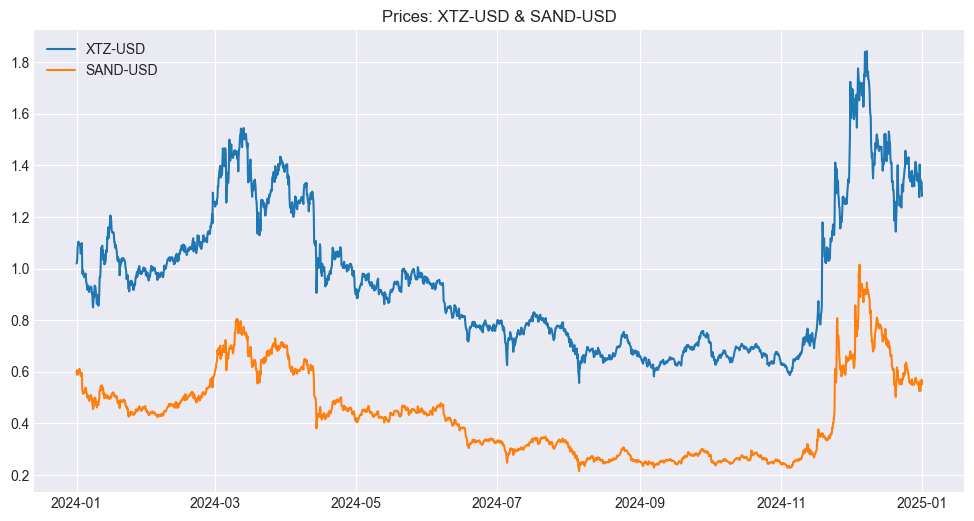

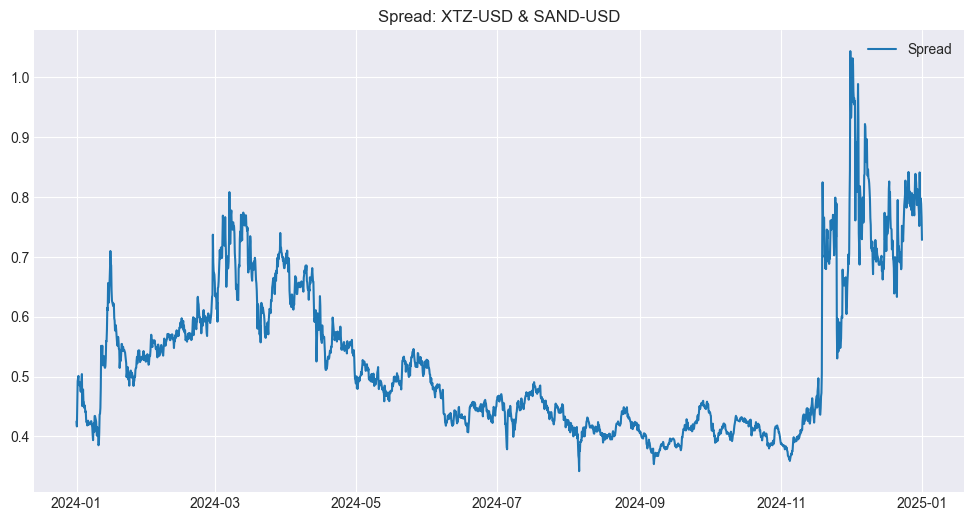


AVAX-USD & EOS-USD
  p-value: 0.0000
  Hurst Exponent of Spread: 0.6399


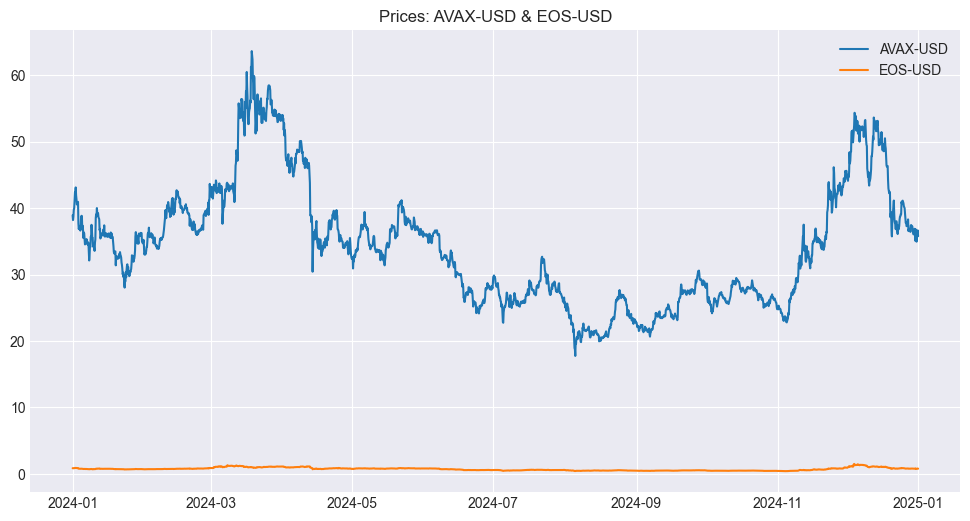

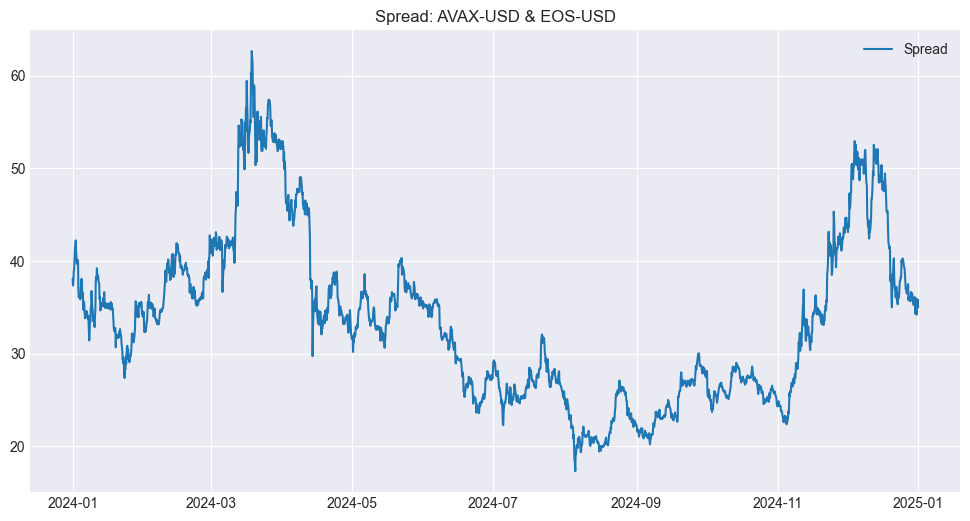


ETC-USD & EOS-USD
  p-value: 0.0001
  Hurst Exponent of Spread: 0.5676


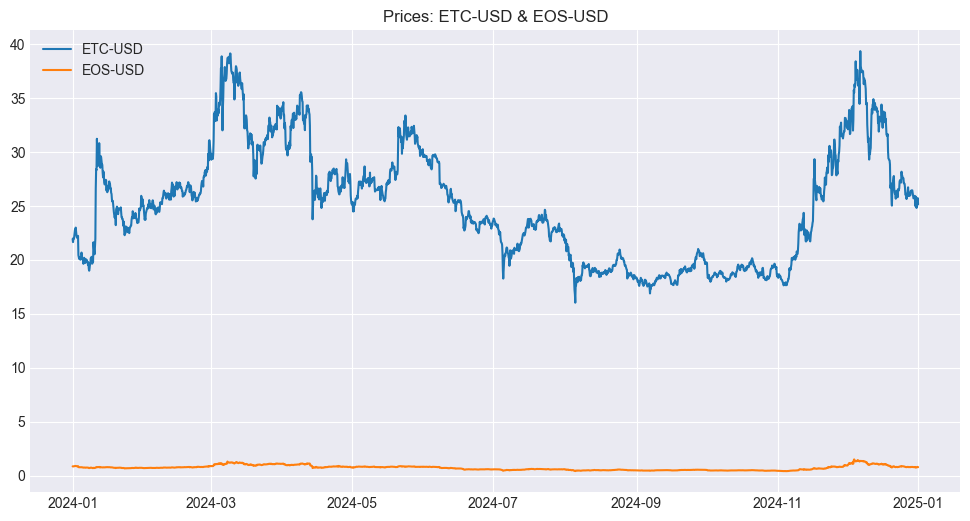

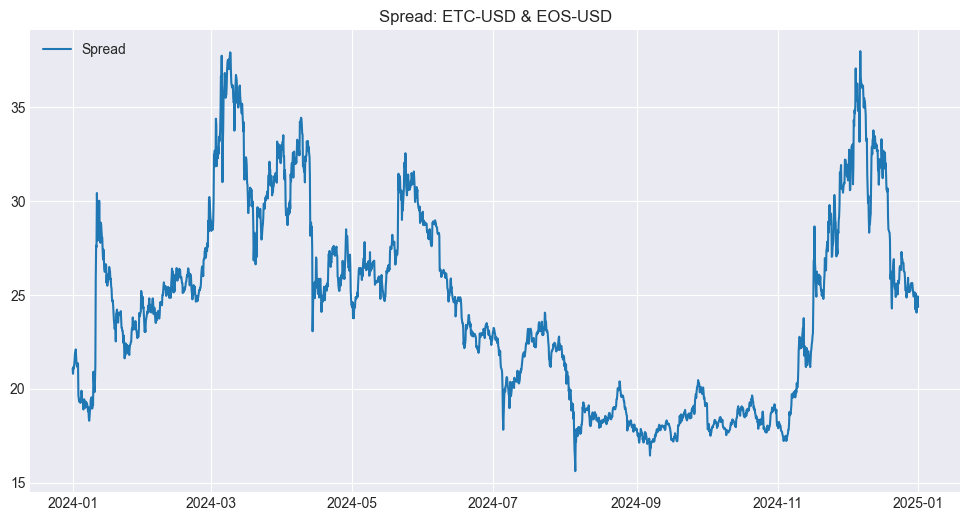


AVAX-USD & MANA-USD
  p-value: 0.0002
  Hurst Exponent of Spread: 0.6392


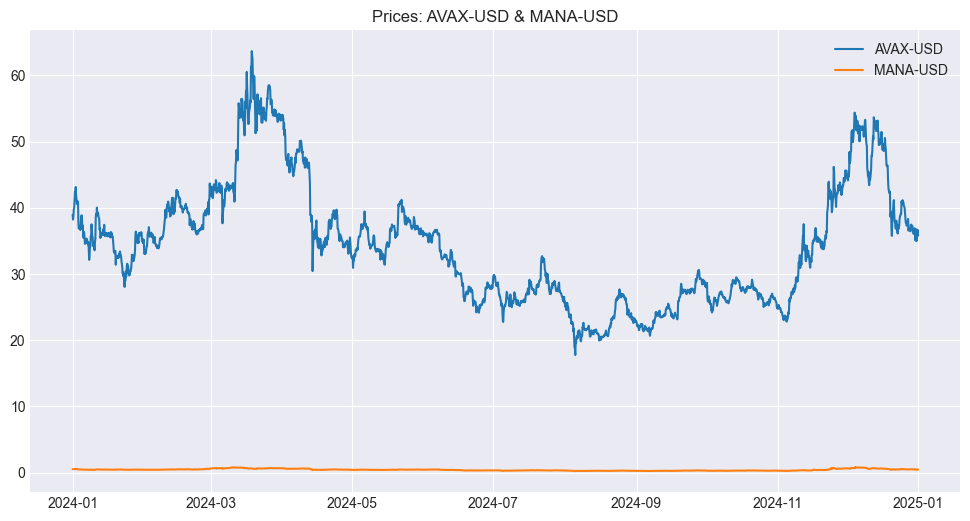

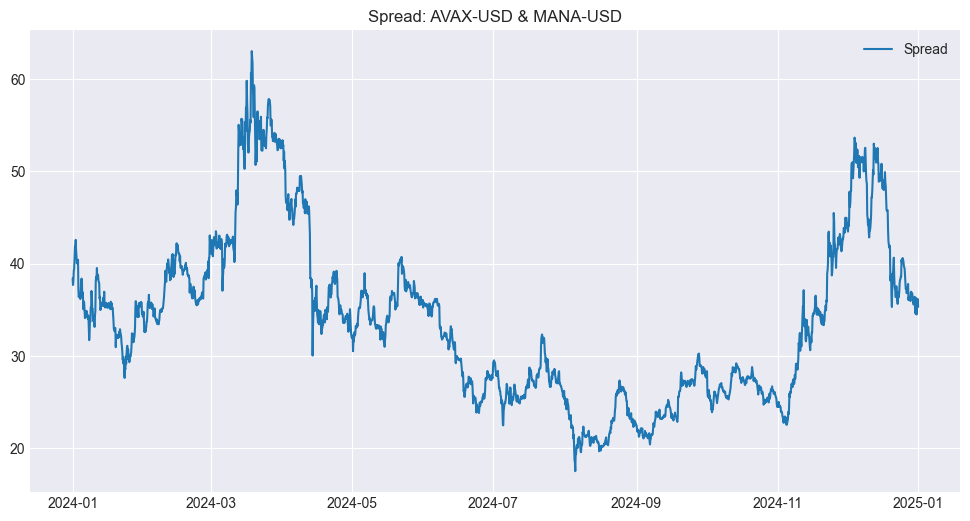


AVAX-USD & ETC-USD
  p-value: 0.0006
  Hurst Exponent of Spread: 0.8065


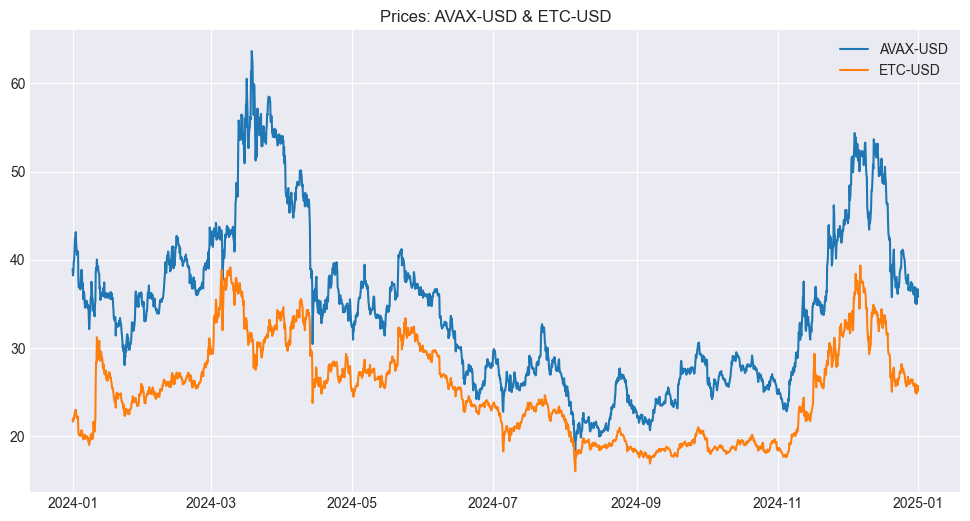

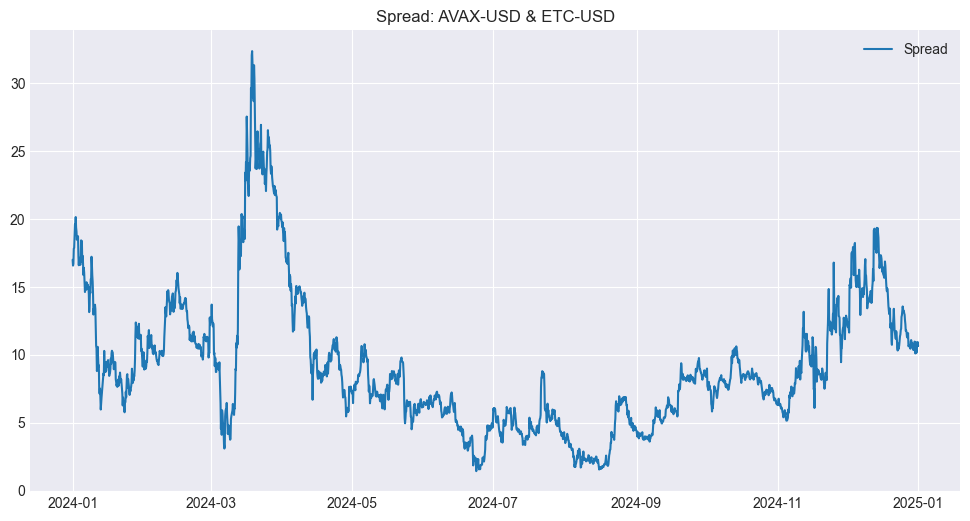

In [13]:
non_stationary_tickers = []
print("\nIdentifying non-stationary series for cointegration analysis:")

for ticker, series in crypto_data_4h.items():
    pval = adf_results_all.get(ticker, {}).get('p_value')
    if pval is None:
        print(f"- {ticker}: missing ADF result.")
        continue
    if pval >= 0.05 and len(series.dropna()) > 20:
        non_stationary_tickers.append(ticker)
        print(f"- {ticker} is non-stationary (p = {pval:.4f})")

cointegrated_pairs = []
print("\nRunning cointegration test...")

for i in range(len(non_stationary_tickers)):
    for j in range(i + 1, len(non_stationary_tickers)):
        coin1, coin2 = non_stationary_tickers[i], non_stationary_tickers[j]
        ts1, ts2 = crypto_data_4h[coin1].dropna(), crypto_data_4h[coin2].dropna()
        
        aligned = pd.concat([ts1, ts2], axis=1, join='inner').dropna()
        if len(aligned) < 50:
            continue

        try:
            score, pval, _ = coint(aligned.iloc[:, 0], aligned.iloc[:, 1])
            if pval <= 0.05:
                model = sm.OLS(aligned.iloc[:, 0], sm.add_constant(aligned.iloc[:, 1]))
                res = model.fit()
                slope_pval = res.pvalues.iloc[1]
                if slope_pval < 0.05:
                    spread = aligned.iloc[:, 0] - aligned.iloc[:, 1]
                    hurst_val, _, _ = compute_Hc(spread.values, kind='price', simplified=True)
                    cointegrated_pairs.append({
                        'Coin 1': coin1,
                        'Coin 2': coin2,
                        'p-value': pval,
                        'Slope_p_value': slope_pval,
                        'Hurst Exponent': hurst_val,
                        'Series1': aligned.iloc[:, 0],
                        'Series2': aligned.iloc[:, 1],
                        'Spread': spread
                    })
        except Exception as e:
            print(f"Error testing {coin1}-{coin2}: {e}")

top5 = pd.DataFrame()

if cointegrated_pairs:
    df = pd.DataFrame(cointegrated_pairs).dropna()
    top5 = df.sort_values(['p-value', 'Hurst Exponent']).head(5)

    print("\nTop 5 Cointegrated Pairs:")
    for _, row in top5.iterrows():
        print(f"\n{row['Coin 1']} & {row['Coin 2']}")
        print(f"  p-value: {row['p-value']:.4f}")
        print(f"  Hurst Exponent of Spread: {row['Hurst Exponent']:.4f}")
        plt.figure(figsize=(12, 6))
        plt.plot(row['Series1'].index, row['Series1'], label=row['Coin 1'])
        plt.plot(row['Series2'].index, row['Series2'], label=row['Coin 2'])
        plt.title(f"Prices: {row['Coin 1']} & {row['Coin 2']}")
        plt.legend()
        plt.show()
        plt.figure(figsize=(12, 6))
        plt.plot(row['Spread'].index, row['Spread'], label='Spread')
        plt.title(f"Spread: {row['Coin 1']} & {row['Coin 2']}")
        plt.legend()
        plt.show()
else:
    print("No cointegrated pairs found.")


Backtesting Pair: XTZ-USD-SAND-USD
  Half-Life: 71.23 (4H periods)
  Sharpe Ratio: 1.1284


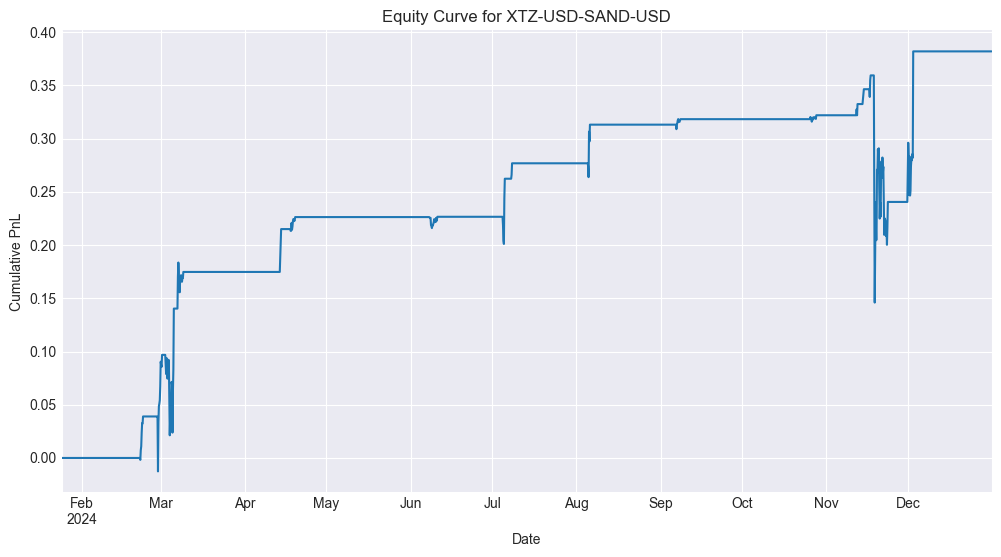


Backtesting Pair: AVAX-USD-EOS-USD
  Half-Life: 185.53 (4H periods)
  Sharpe Ratio: 0.5849


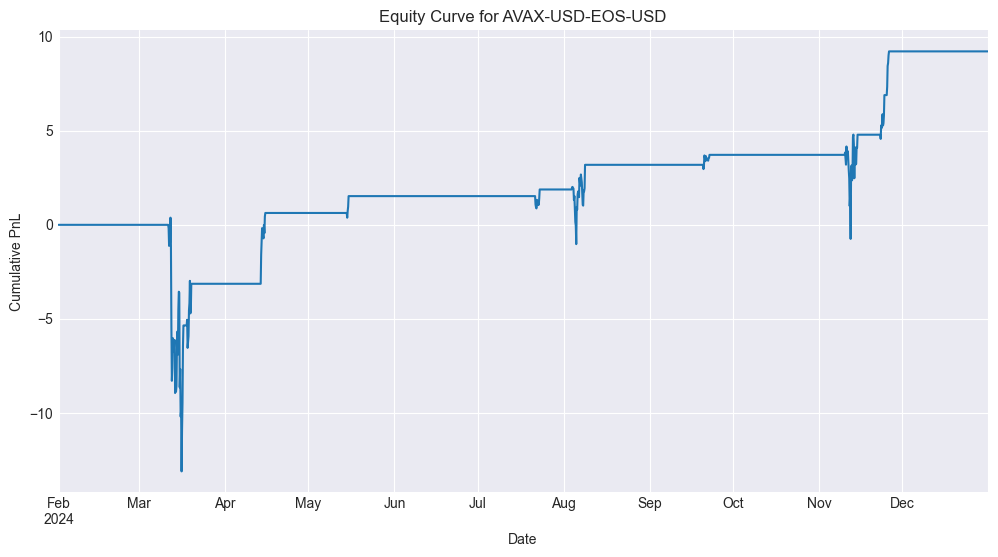


Backtesting Pair: ETC-USD-EOS-USD
  Half-Life: 143.53 (4H periods)
  Sharpe Ratio: 0.1483


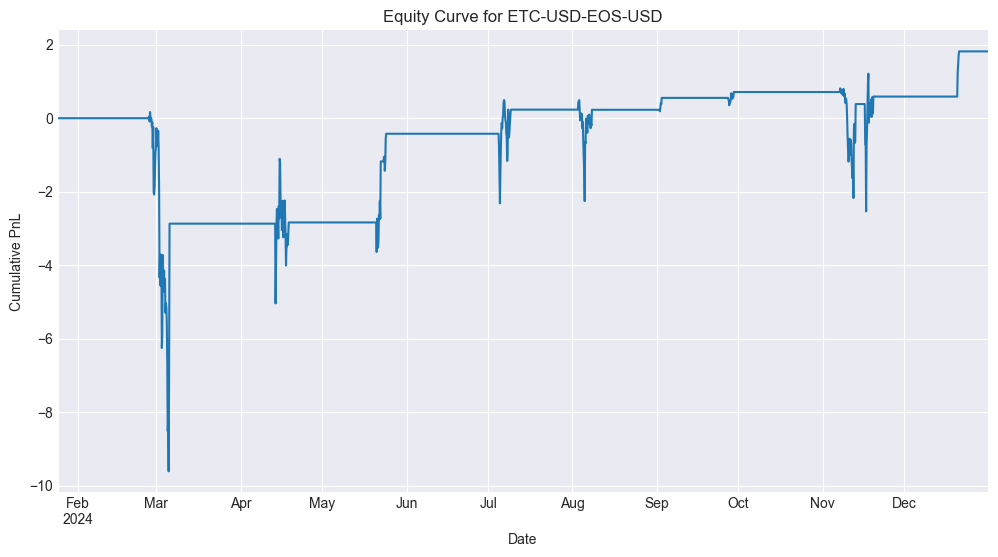


Backtesting Pair: AVAX-USD-MANA-USD
  Half-Life: 186.98 (4H periods)
  Sharpe Ratio: 0.4129


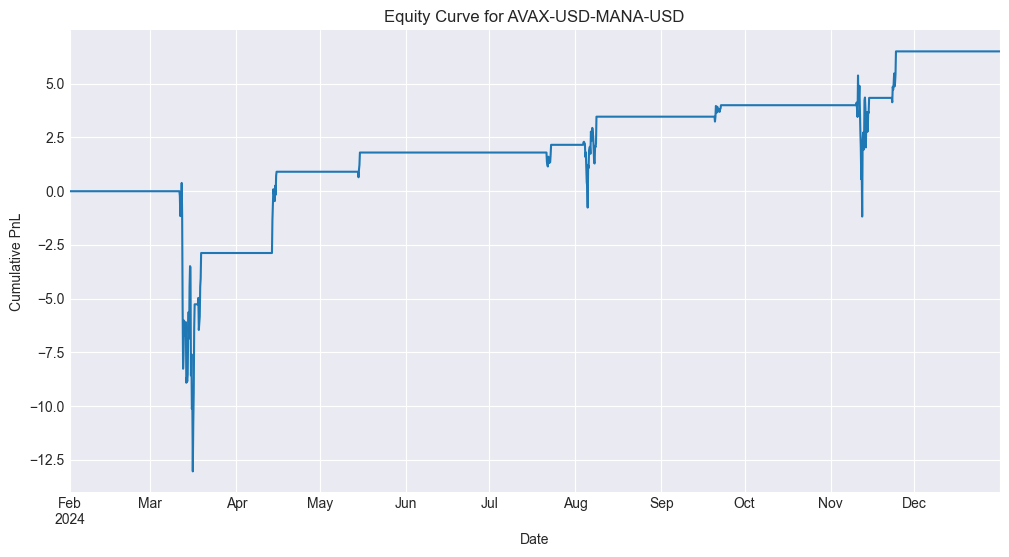


Backtesting Pair: AVAX-USD-ETC-USD
  Half-Life: 97.85 (4H periods)
  Sharpe Ratio: 0.8230


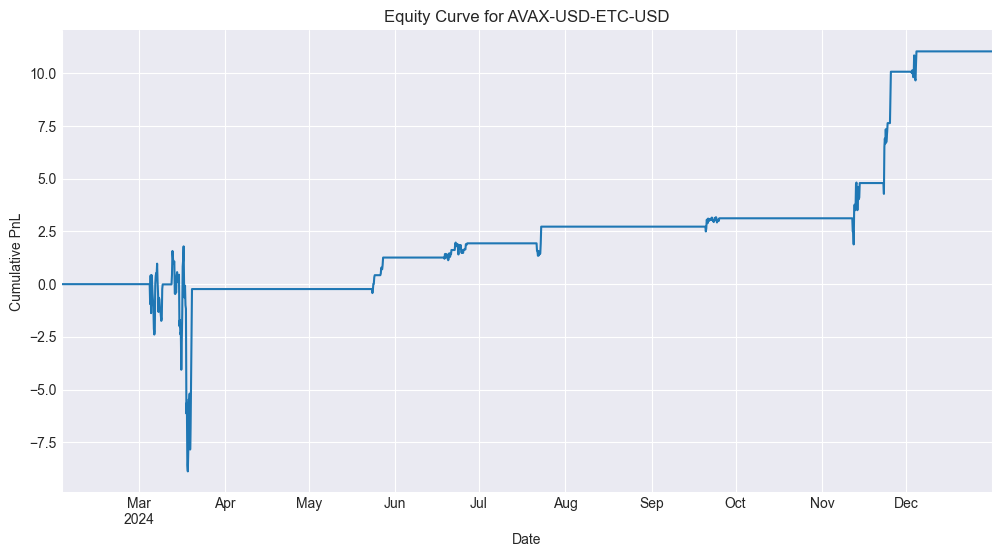

In [14]:
def calculate_bollinger_bands_lookback(half_life_periods):
    min_lookback_days = 20
    periods_per_day = 24 / 4
    min_lookback_periods = int(min_lookback_days * periods_per_day)

    if pd.isna(half_life_periods) or half_life_periods <= 0:
        return min_lookback_periods

    hl_int_periods = max(1, int(round(half_life_periods)))

    if hl_int_periods < min_lookback_periods:
        multiplier = np.ceil(min_lookback_periods / hl_int_periods)
        lookback_period = int(multiplier * hl_int_periods)
    else:
        lookback_period = hl_int_periods
        
    return max(2, lookback_period)

def get_bollinger_bands(series_data, lookback_period):
    if lookback_period >= len(series_data):
        nan_series = pd.Series(np.nan, index=series_data.index)
        return (nan_series, nan_series, nan_series, nan_series, nan_series, nan_series, nan_series)

    middle_band_ema = series_data.ewm(span=lookback_period, adjust=False).mean()
    standard_deviation = series_data.rolling(window=lookback_period).std()

    upper_band_full_entry = middle_band_ema + 3.5 * standard_deviation
    upper_band_entry = middle_band_ema + 2.5 * standard_deviation
    upper_band_exit = middle_band_ema + 1.5 * standard_deviation

    lower_band_exit = middle_band_ema - 1.5 * standard_deviation
    lower_band_entry = middle_band_ema - 2.5 * standard_deviation
    lower_band_full_entry = middle_band_ema - 3.5 * standard_deviation

    return (
        middle_band_ema, upper_band_exit, upper_band_entry, upper_band_full_entry, 
        lower_band_exit, lower_band_entry, lower_band_full_entry
    )

def backtest_bb_strategy(spread_series, lookback_period):
    (
        middle_band, upper_exit, upper_entry, upper_full, 
        lower_exit, lower_entry, lower_full
    ) = get_bollinger_bands(spread_series, lookback_period)
    
    signals = pd.DataFrame(index=spread_series.index)
    signals['price'] = spread_series
    signals['middle_band'] = middle_band
    signals['upper_exit_band'] = upper_exit
    signals['upper_entry_band'] = upper_entry
    signals['upper_full_entry_band'] = upper_full
    signals['lower_exit_band'] = lower_exit
    signals['lower_entry_band'] = lower_entry
    signals['lower_full_entry_band'] = lower_full
    signals.dropna(inplace=True)

    if signals.empty:
        return pd.Series(dtype=float)

    position = 0
    positions = pd.Series(0.0, index=signals.index)
    
    for i in range(1, len(signals)):
        price = signals['price'][i]
        
        if position == 0:
            if price > signals['upper_entry_band'][i-1]:
                position = -0.5
            elif price < signals['lower_entry_band'][i-1]:
                position = 0.5
        
        elif position == 0.5:
            if price < signals['lower_full_entry_band'][i-1]:
                position = 1.0
            elif price >= signals['lower_exit_band'][i-1]:
                position = 0
        
        elif position == -0.5:
            if price > signals['upper_full_entry_band'][i-1]:
                position = -1.0
            elif price <= signals['upper_exit_band'][i-1]:
                position = 0
        
        elif position == 1.0:
            if price >= signals['lower_exit_band'][i-1]:
                position = 0

        elif position == -1.0:
            if price <= signals['upper_exit_band'][i-1]:
                position = 0
        
        positions[i] = position
        
    returns = signals['price'].diff()
    pnl = positions.shift(1) * returns
    equity_curve = pnl.cumsum()
    
    return equity_curve

def calculate_sharpe_ratio(equity_curve):
    if equity_curve.empty:
        return 0.0
    
    returns = equity_curve.diff().dropna()
    mean_ret = returns.mean()
    std_ret = returns.std()
    if std_ret == 0:
        return 0.0
    return mean_ret / std_ret * np.sqrt(252 * 6) 

if not top5.empty:
    for _, row in top5.iterrows():
        pair_name = f"{row['Coin 1']}-{row['Coin 2']}"
        print(f"\nBacktesting Pair: {pair_name}")
        half_life = calculate_mean_reversion_half_life(row['Spread'])
        if half_life == np.inf or pd.isna(half_life):
            half_life = 120

        lookback = calculate_bollinger_bands_lookback(half_life)
        
        print(f"  Half-Life: {half_life:.2f} (4H periods)")

        equity = backtest_bb_strategy(row['Spread'], lookback)
        
        if equity.empty:
            print("  Could not generate equity curve, likely due to insufficient data for the lookback period.")
            continue

        sharpe = calculate_sharpe_ratio(equity)
        print(f"  Sharpe Ratio: {sharpe:.4f}")

        plt.figure(figsize=(12, 6))
        equity.plot()
        plt.title(f'Equity Curve for {pair_name}')
        plt.xlabel('Date')
        plt.ylabel('Cumulative PnL')
        plt.show()
else:
    print("\nNo cointegrated pairs found in Part 3 (variable 'top5' is empty or not defined). Cannot run backtest.")


Comparing Strategies for Pair: XTZ-USD-SAND-USD
  Half-Life: 71.23 (4H periods)
  EMA BB Sharpe Ratio: 1.1284
  Kalman Filter BB Sharpe Ratio: 1.4329
  Number of Trades (Kalman): 14


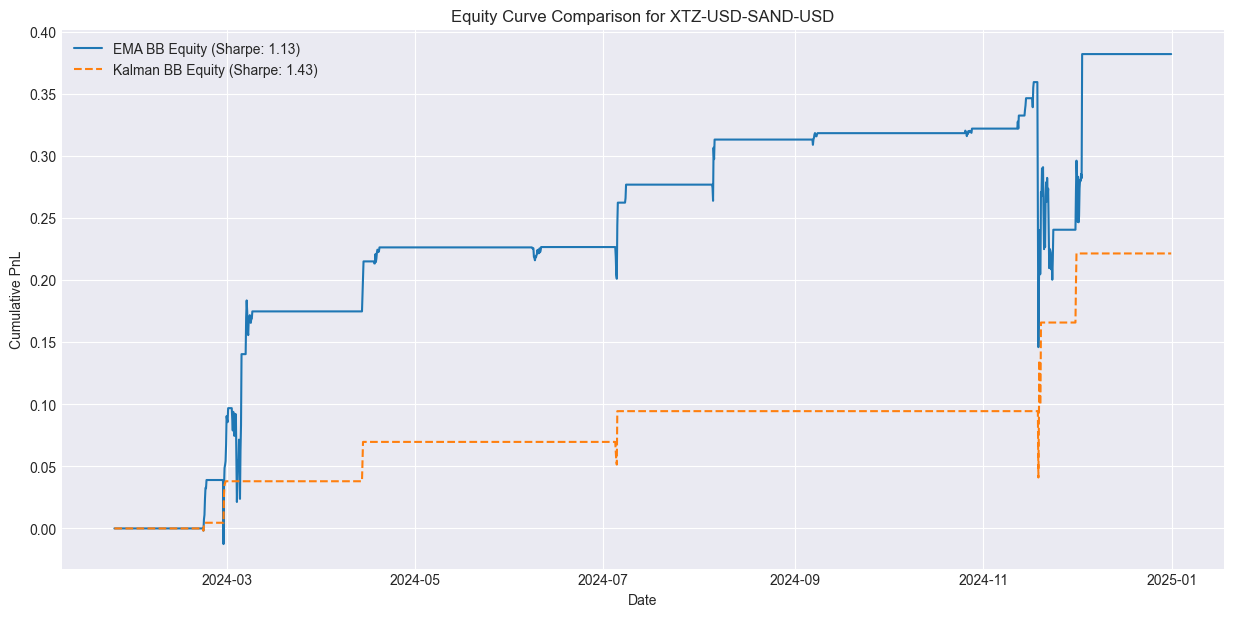

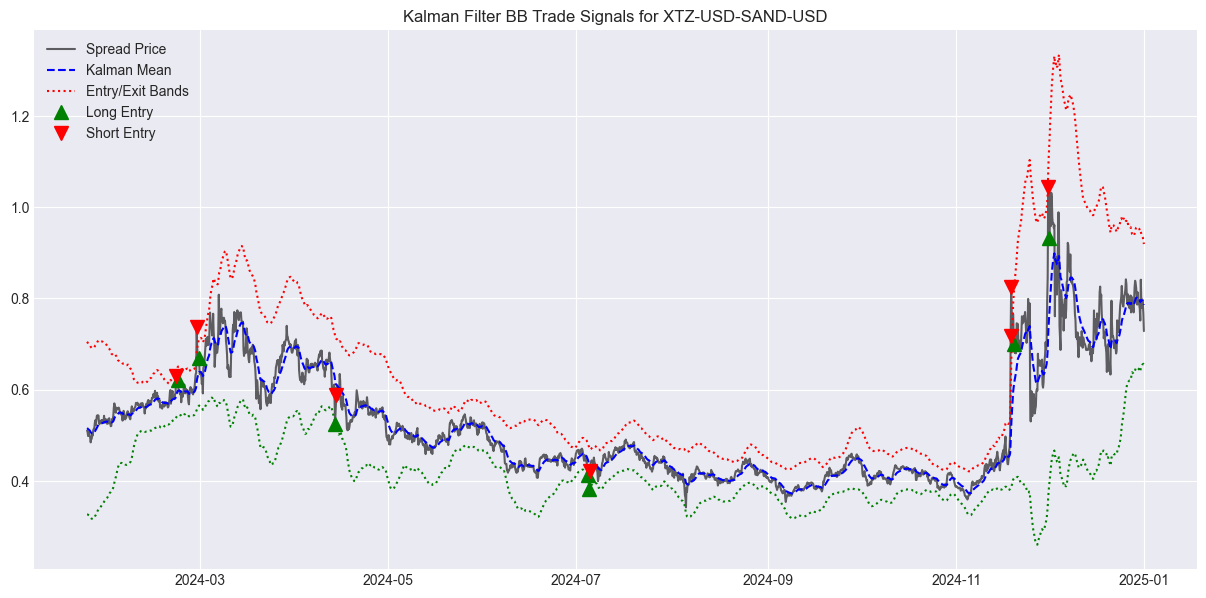


Comparing Strategies for Pair: AVAX-USD-EOS-USD
  Half-Life: 185.53 (4H periods)
  EMA BB Sharpe Ratio: 0.5849
  Kalman Filter BB Sharpe Ratio: 0.7290
  Number of Trades (Kalman): 7


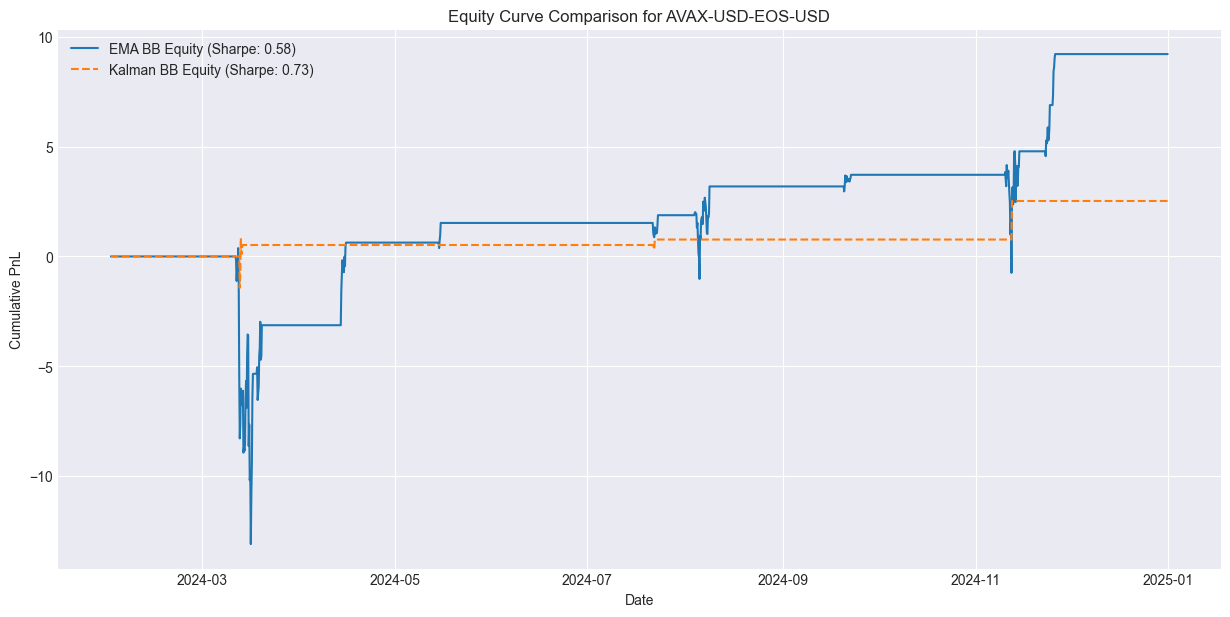

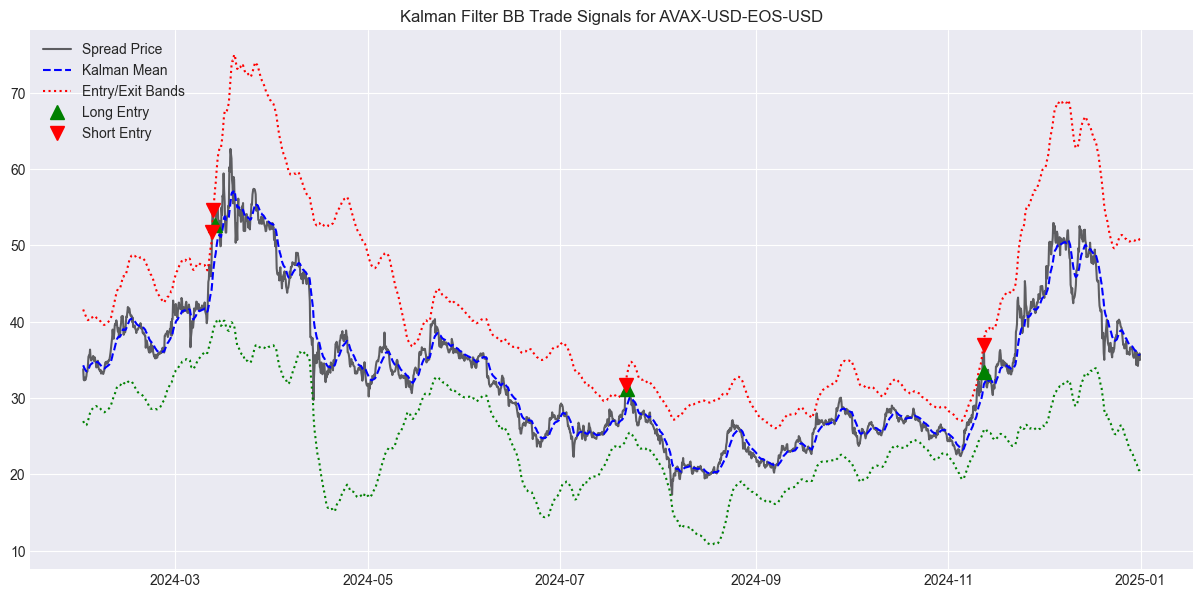


Comparing Strategies for Pair: ETC-USD-EOS-USD
  Half-Life: 143.53 (4H periods)
  EMA BB Sharpe Ratio: 0.1483
  Kalman Filter BB Sharpe Ratio: 0.7791
  Number of Trades (Kalman): 20


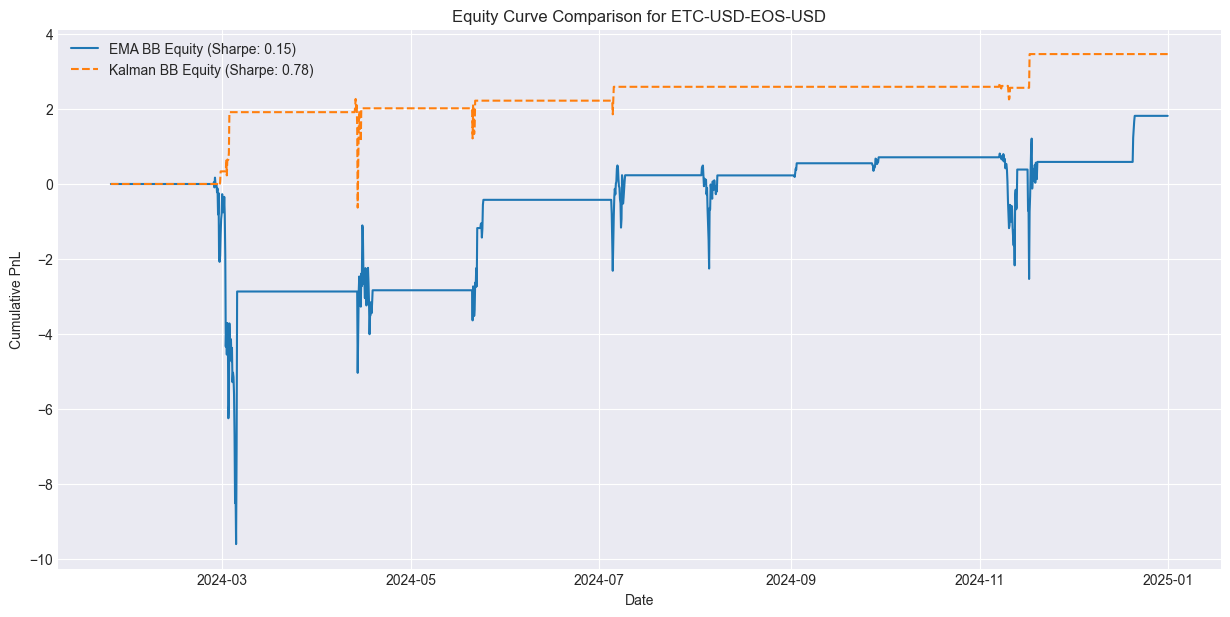

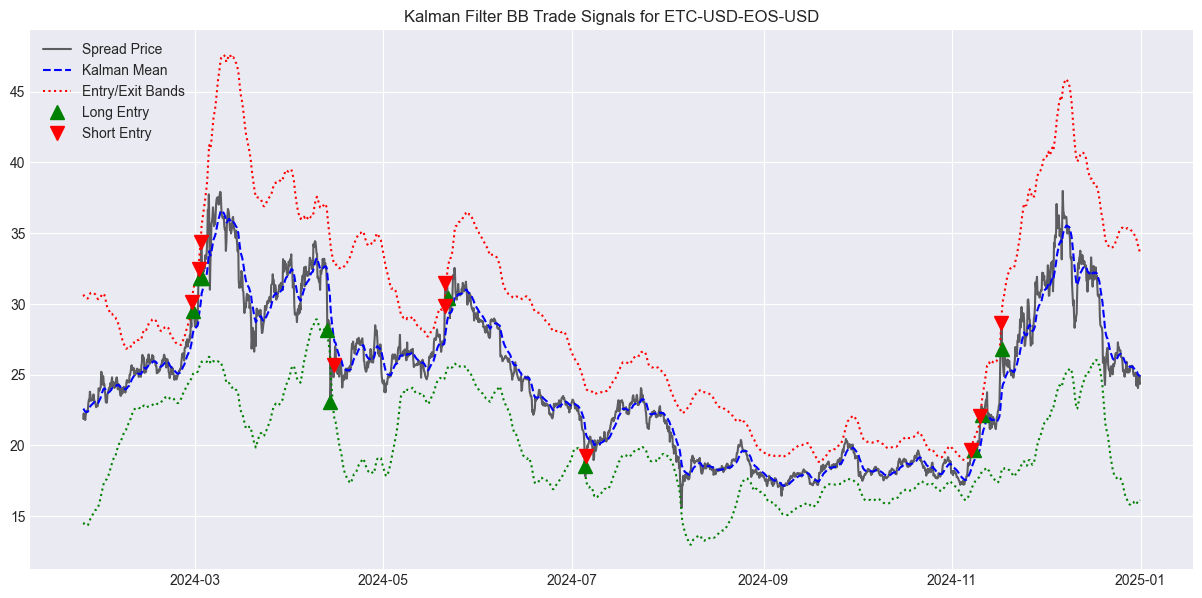


Comparing Strategies for Pair: AVAX-USD-MANA-USD
  Half-Life: 186.98 (4H periods)
  EMA BB Sharpe Ratio: 0.4129
  Kalman Filter BB Sharpe Ratio: 0.2734
  Number of Trades (Kalman): 5


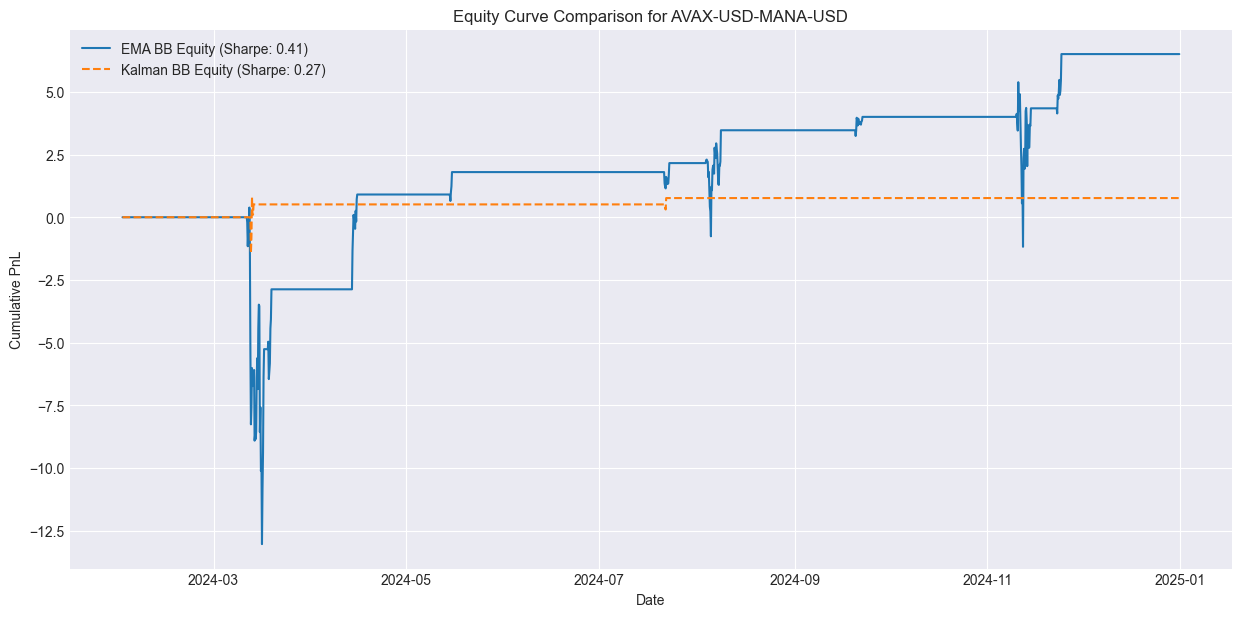

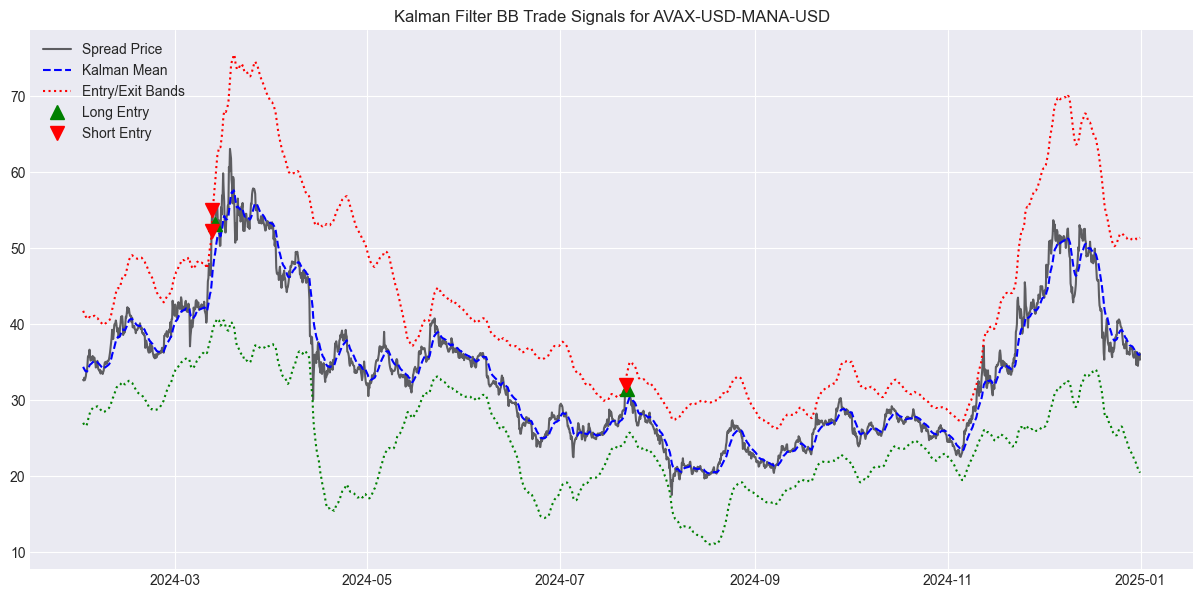


Comparing Strategies for Pair: AVAX-USD-ETC-USD
  Half-Life: 97.85 (4H periods)
  EMA BB Sharpe Ratio: 0.8230
  Kalman Filter BB Sharpe Ratio: 0.9151
  Number of Trades (Kalman): 12


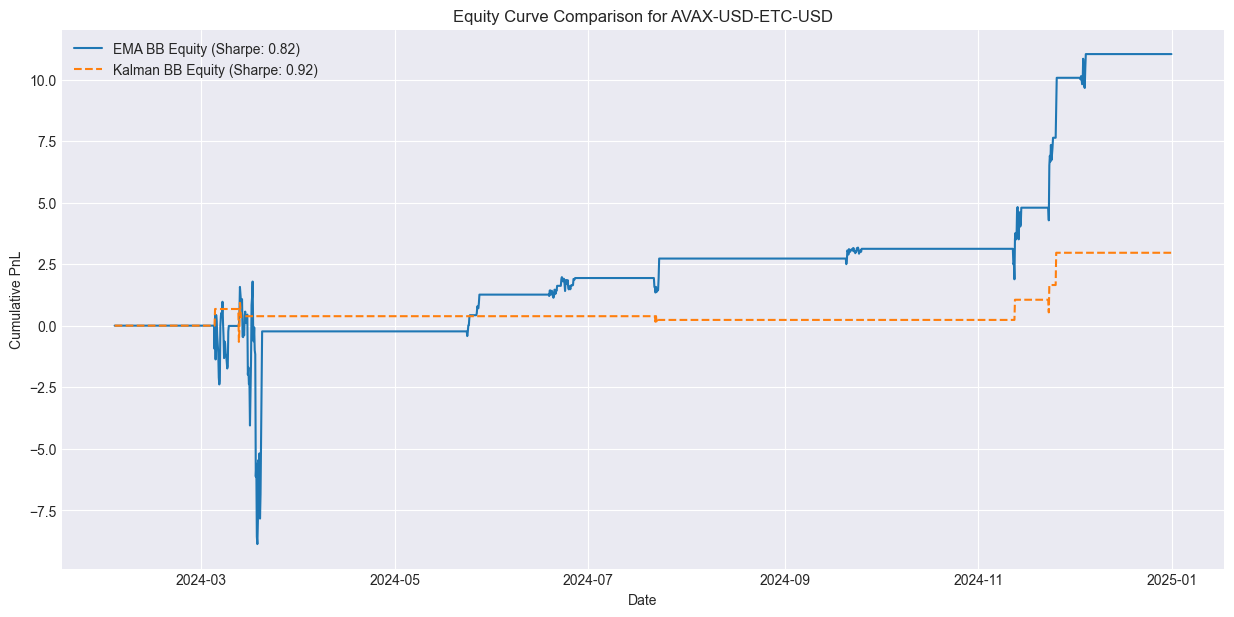

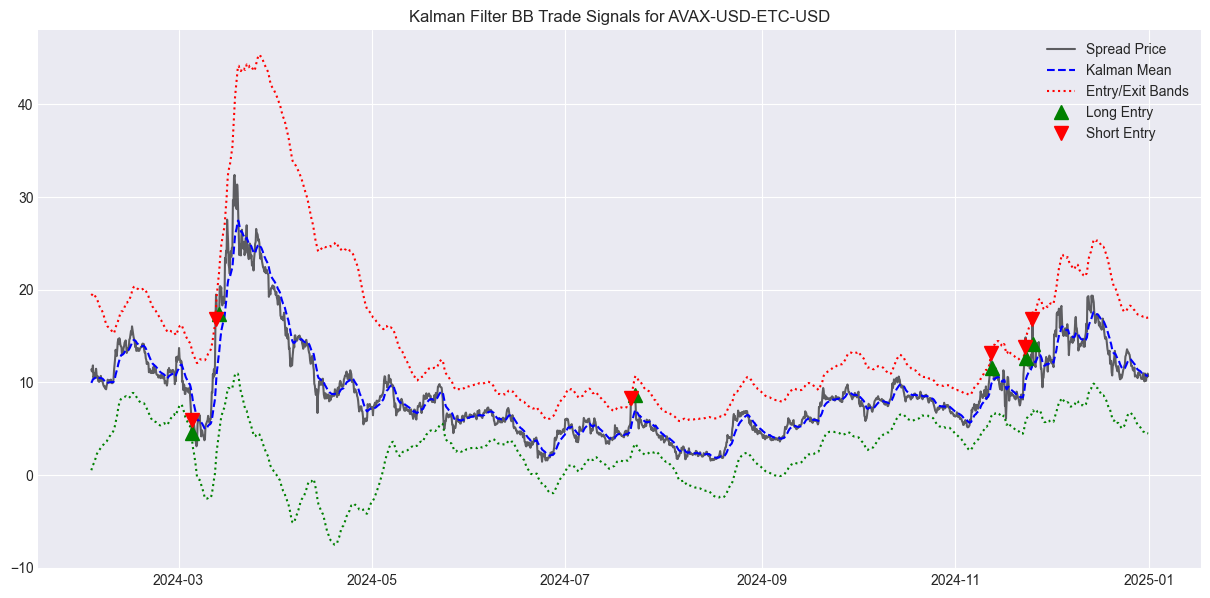

In [15]:
def kalman_filter_mean(series):
    kf = KalmanFilter(
        transition_matrices=[1],
        observation_matrices=[1],
        initial_state_mean=series.iloc[0],
        initial_state_covariance=1,
        observation_covariance=1,
        transition_covariance=0.01
    )
    state_means, _ = kf.filter(series.values)
    return pd.Series(state_means.flatten(), index=series.index)

def backtest_kalman_bb_strategy(spread_series, lookback_period):
    kalman_middle_band = kalman_filter_mean(spread_series)
    standard_deviation = spread_series.rolling(window=lookback_period).std()
    
    upper_band_full_entry = kalman_middle_band + 3.5 * standard_deviation
    upper_band_entry = kalman_middle_band + 2.5 * standard_deviation
    upper_band_exit = kalman_middle_band + 1.5 * standard_deviation

    lower_band_exit = kalman_middle_band - 1.5 * standard_deviation
    lower_band_entry = kalman_middle_band - 2.5 * standard_deviation
    lower_band_full_entry = kalman_middle_band - 3.5 * standard_deviation

    signals = pd.DataFrame(index=spread_series.index)
    signals['price'] = spread_series
    signals['middle_band'] = kalman_middle_band
    signals['upper_exit_band'] = upper_band_exit
    signals['upper_entry_band'] = upper_band_entry
    signals['upper_full_entry_band'] = upper_band_full_entry
    signals['lower_exit_band'] = lower_band_exit
    signals['lower_entry_band'] = lower_band_entry
    signals['lower_full_entry_band'] = lower_band_full_entry
    signals.dropna(inplace=True)

    if signals.empty:
        return pd.Series(dtype=float), pd.DataFrame(), 0

    position = 0
    positions = pd.Series(0.0, index=signals.index)
    trades = []
    
    for i in range(1, len(signals)):
        price = signals['price'][i]
        
        if position == 0:
            if price < signals['lower_entry_band'][i-1]:
                position = 0.5
                trades.append({'Date': signals.index[i], 'Type': 'Buy', 'Price': price})
            elif price > signals['upper_entry_band'][i-1]:
                position = -0.5
                trades.append({'Date': signals.index[i], 'Type': 'Sell', 'Price': price})
        
        elif position == 0.5:
            if price < signals['lower_full_entry_band'][i-1]:
                position = 1.0
                trades.append({'Date': signals.index[i], 'Type': 'AddBuy', 'Price': price})
            elif price >= signals['lower_exit_band'][i-1]:
                position = 0
                trades.append({'Date': signals.index[i], 'Type': 'Exit', 'Price': price})

        elif position == -0.5:
            if price > signals['upper_full_entry_band'][i-1]:
                position = -1.0
                trades.append({'Date': signals.index[i], 'Type': 'AddSell', 'Price': price})
            elif price <= signals['upper_exit_band'][i-1]:
                position = 0
                trades.append({'Date': signals.index[i], 'Type': 'Exit', 'Price': price})
        
        elif position == 1.0:
            if price >= signals['lower_exit_band'][i-1]:
                position = 0
                trades.append({'Date': signals.index[i], 'Type': 'Exit', 'Price': price})

        elif position == -1.0:
            if price <= signals['upper_exit_band'][i-1]:
                position = 0
                trades.append({'Date': signals.index[i], 'Type': 'Exit', 'Price': price})
        
        positions[i] = position
        
    signals['position'] = positions
    returns = signals['price'].diff()
    pnl = signals['position'].shift(1) * returns
    equity_curve = pnl.cumsum()
    
    return equity_curve, signals, len(trades)

if not top5.empty:
    for _, row in top5.iterrows():
        pair_name = f"{row['Coin 1']}-{row['Coin 2']}"
        half_life = calculate_mean_reversion_half_life(row['Spread'])
        if half_life == np.inf or pd.isna(half_life):
            half_life = 120

        lookback = calculate_bollinger_bands_lookback(half_life)
        
        print(f"\nComparing Strategies for Pair: {pair_name}")
        print(f"  Half-Life: {half_life:.2f} (4H periods)")

        ema_equity = backtest_bb_strategy(row['Spread'], lookback)
        kalman_equity, kalman_signals, kalman_trade_count = backtest_kalman_bb_strategy(row['Spread'], lookback)

        ema_sharpe = calculate_sharpe_ratio(ema_equity)
        kalman_sharpe = calculate_sharpe_ratio(kalman_equity)
        
        print(f"  EMA BB Sharpe Ratio: {ema_sharpe:.4f}")
        print(f"  Kalman Filter BB Sharpe Ratio: {kalman_sharpe:.4f}")
        print(f"  Number of Trades (Kalman): {kalman_trade_count}")

        if not kalman_equity.empty:
            plt.figure(figsize=(15, 7))
            plt.plot(ema_equity, label=f'EMA BB Equity (Sharpe: {ema_sharpe:.2f})')
            plt.plot(kalman_equity, label=f'Kalman BB Equity (Sharpe: {kalman_sharpe:.2f})', linestyle='--')
            plt.title(f'Equity Curve Comparison for {pair_name}')
            plt.xlabel('Date')
            plt.ylabel('Cumulative PnL')
            plt.legend()
            plt.show()

            plt.figure(figsize=(15, 7))
            plt.plot(kalman_signals['price'], label='Spread Price', color='k', alpha=0.6)
            plt.plot(kalman_signals['middle_band'], label='Kalman Mean', color='b', linestyle='--')
            plt.plot(kalman_signals['upper_entry_band'], label='Entry/Exit Bands', color='r', linestyle=':')
            plt.plot(kalman_signals['lower_entry_band'], color='g', linestyle=':')

            buy_signals = kalman_signals[kalman_signals['position'] > kalman_signals['position'].shift(1)]
            sell_signals = kalman_signals[kalman_signals['position'] < kalman_signals['position'].shift(1)]
            
            plt.plot(buy_signals.index, buy_signals['price'], '^', markersize=10, color='g', label='Long Entry')
            plt.plot(sell_signals.index, sell_signals['price'], 'v', markersize=10, color='r', label='Short Entry')
            plt.title(f'Kalman Filter BB Trade Signals for {pair_name}')
            plt.legend()
            plt.show()
else:
    print("\nNo cointegrated pairs found in Part 3 (variable 'top5' is empty or not defined). Cannot run Kalman Filter comparison.")


XTZ-USD-SAND-USD EMA BB Sharpe: 1.1284, Kalman BB Sharpe: 1.4329, Trades: 14


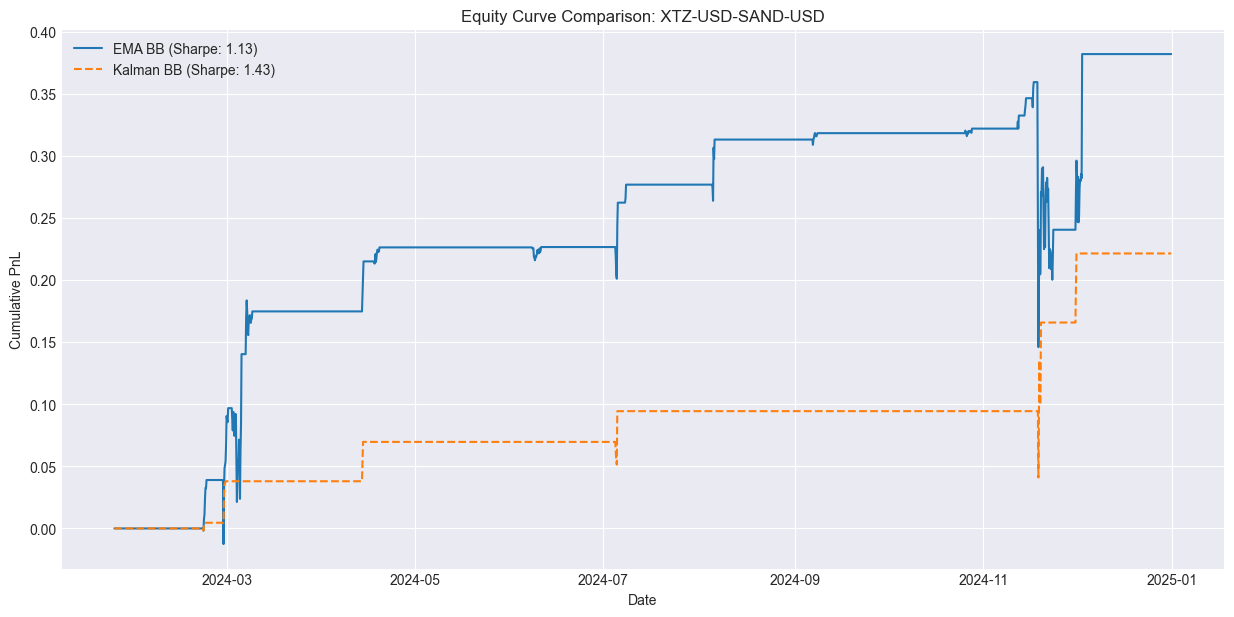

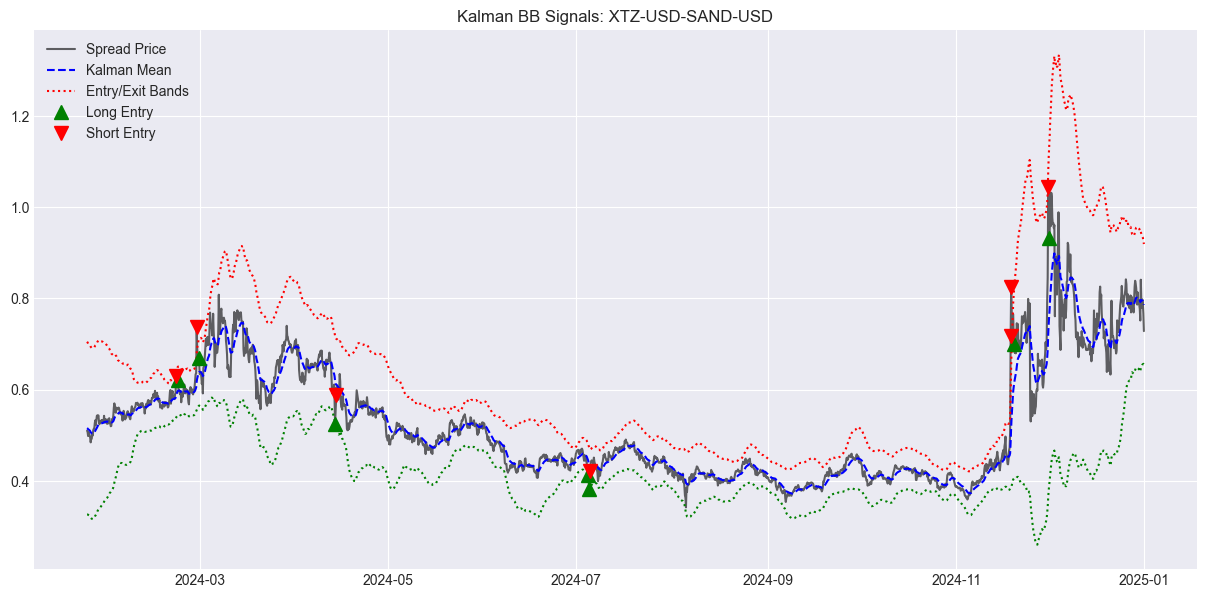

AVAX-USD-EOS-USD EMA BB Sharpe: 0.5849, Kalman BB Sharpe: 0.7290, Trades: 7


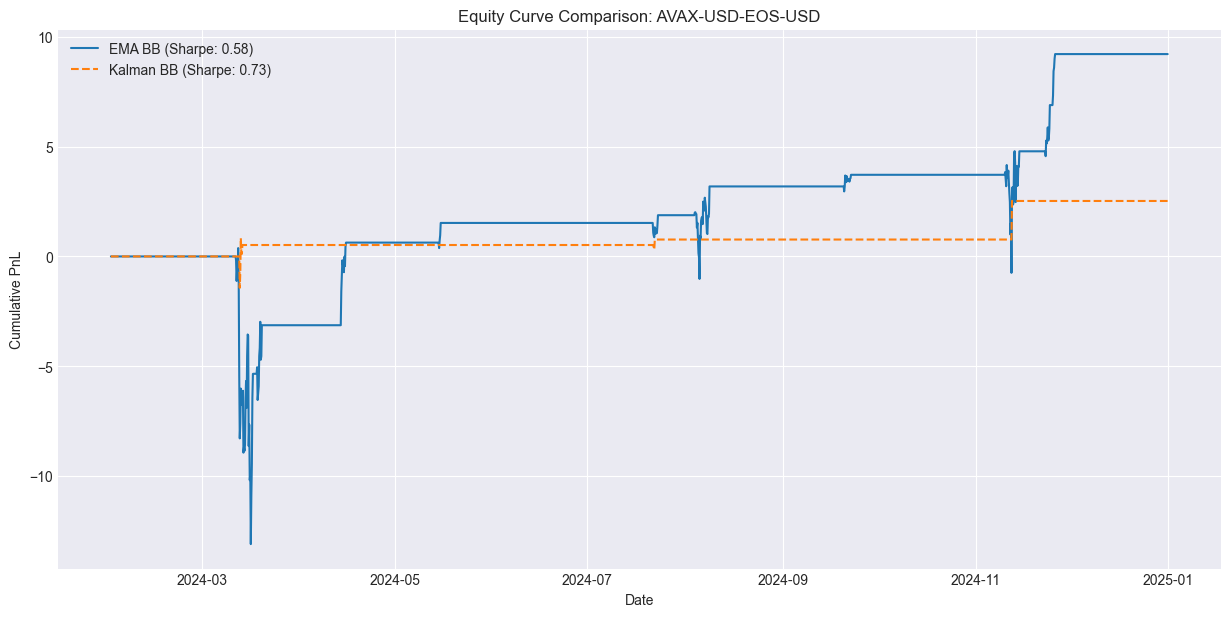

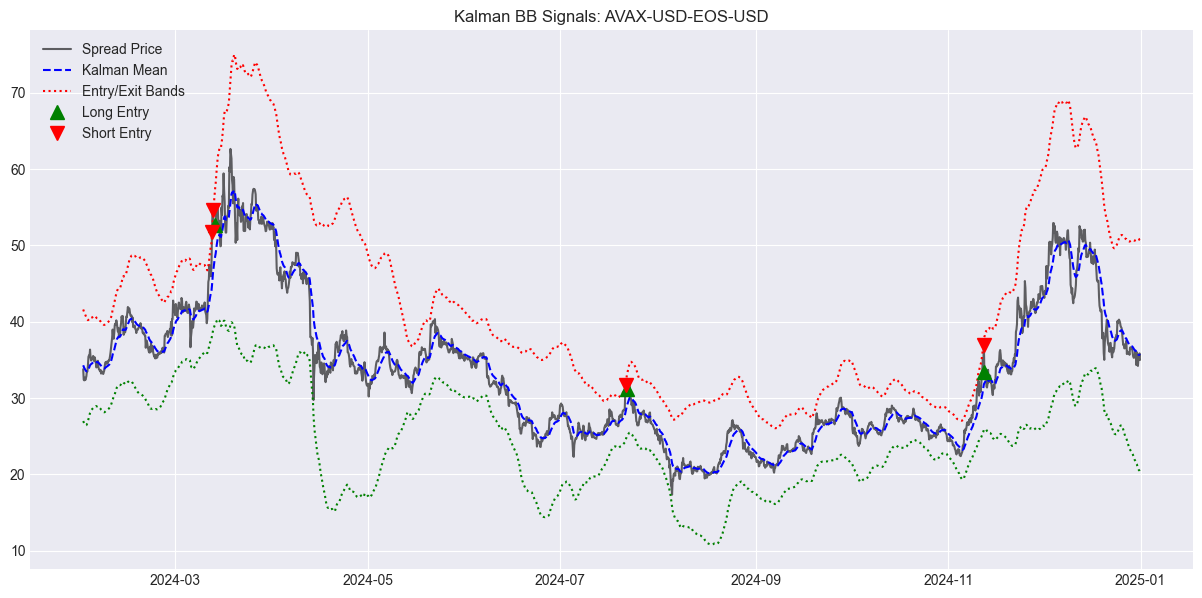

ETC-USD-EOS-USD EMA BB Sharpe: 0.1483, Kalman BB Sharpe: 0.7791, Trades: 20


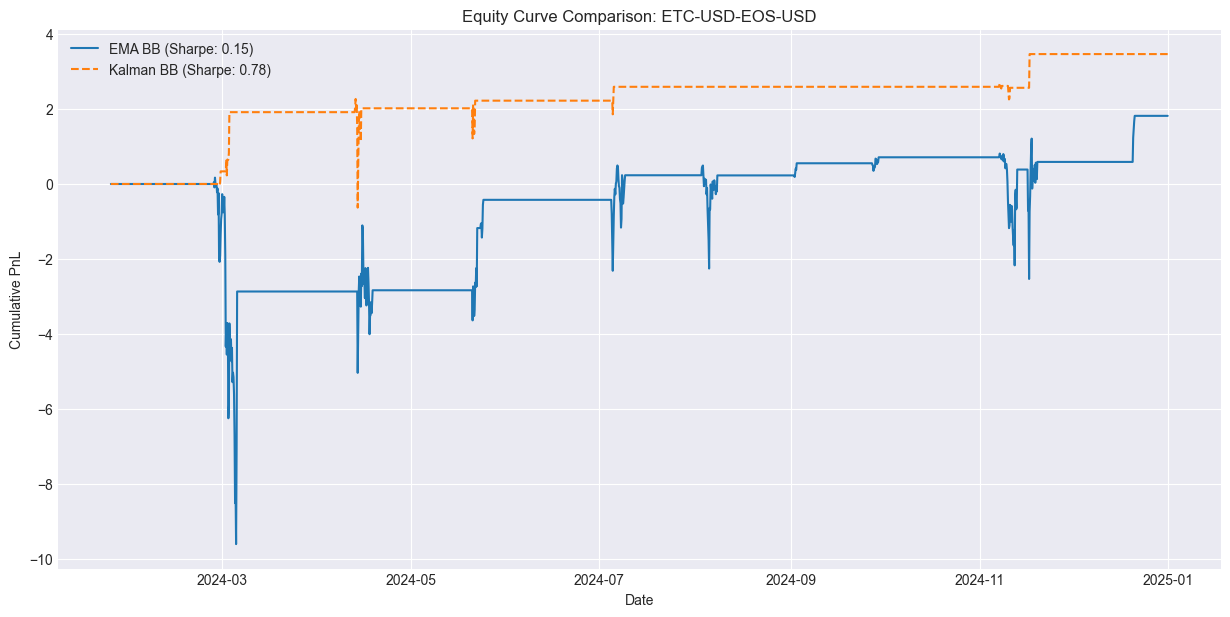

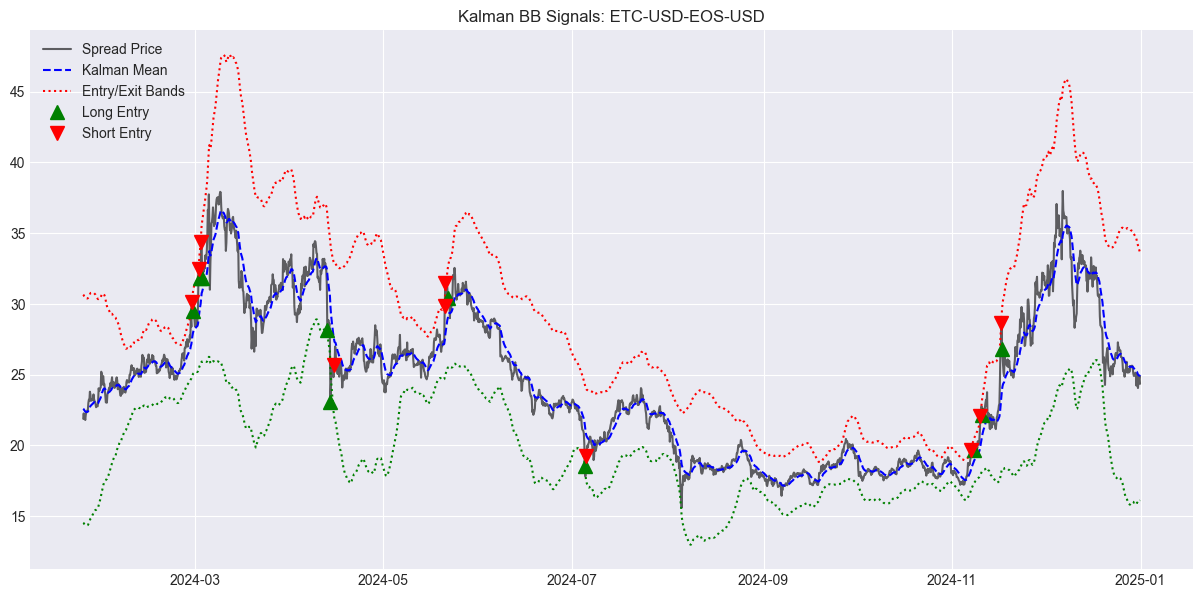

AVAX-USD-MANA-USD EMA BB Sharpe: 0.4129, Kalman BB Sharpe: 0.2734, Trades: 5


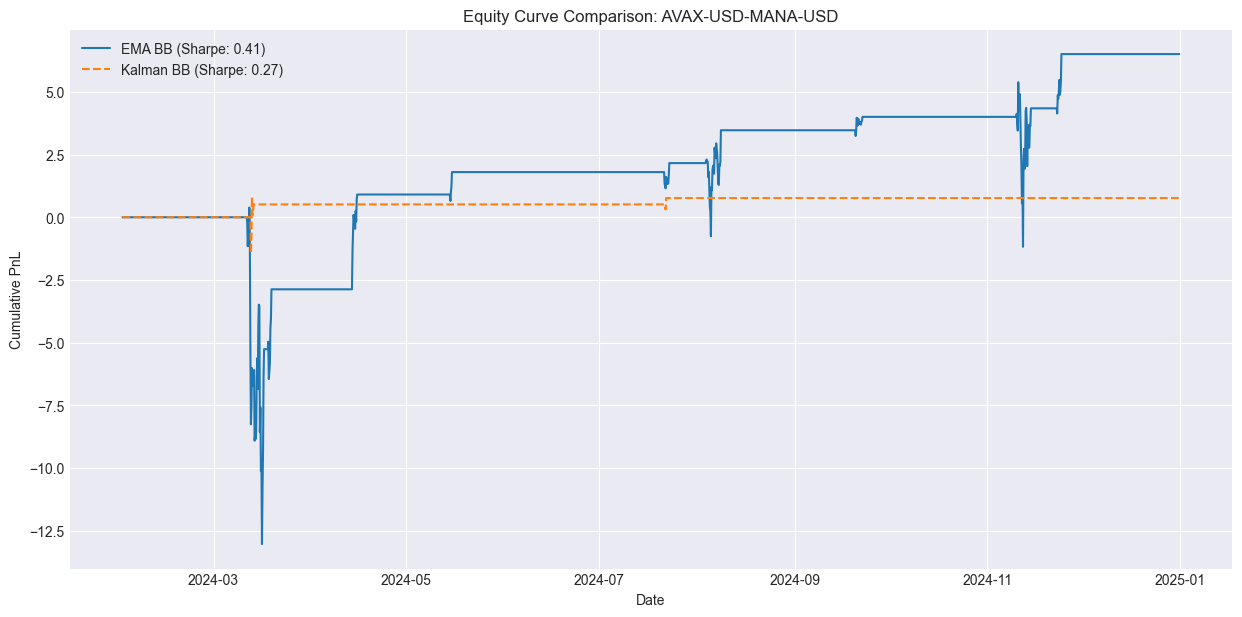

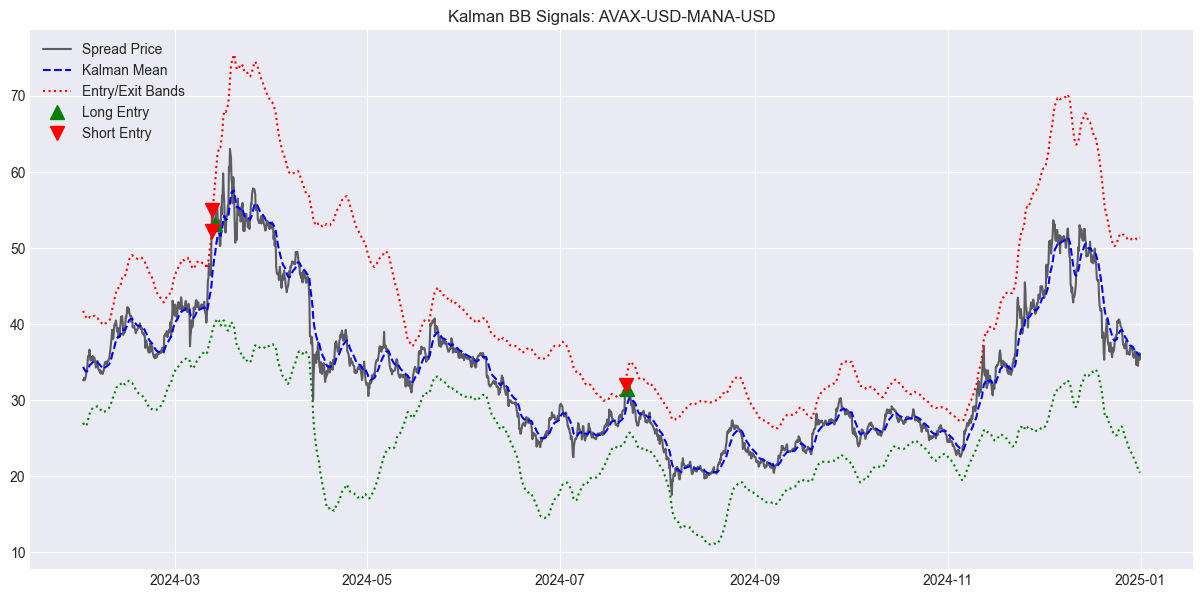

AVAX-USD-ETC-USD EMA BB Sharpe: 0.8230, Kalman BB Sharpe: 0.9151, Trades: 12


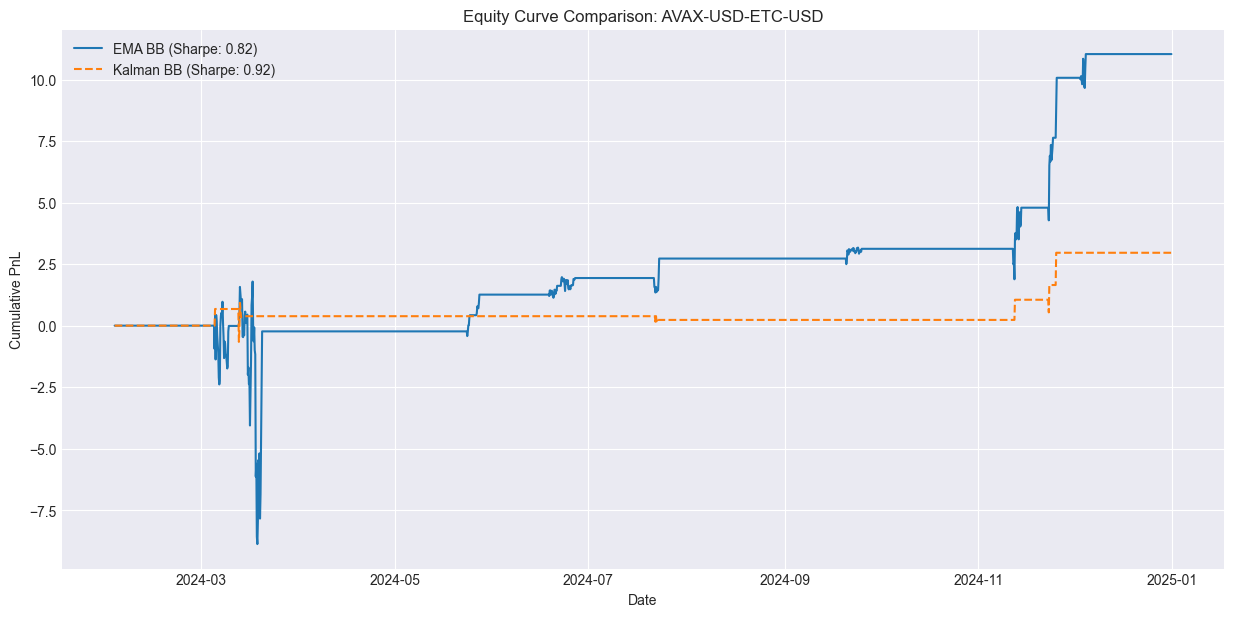

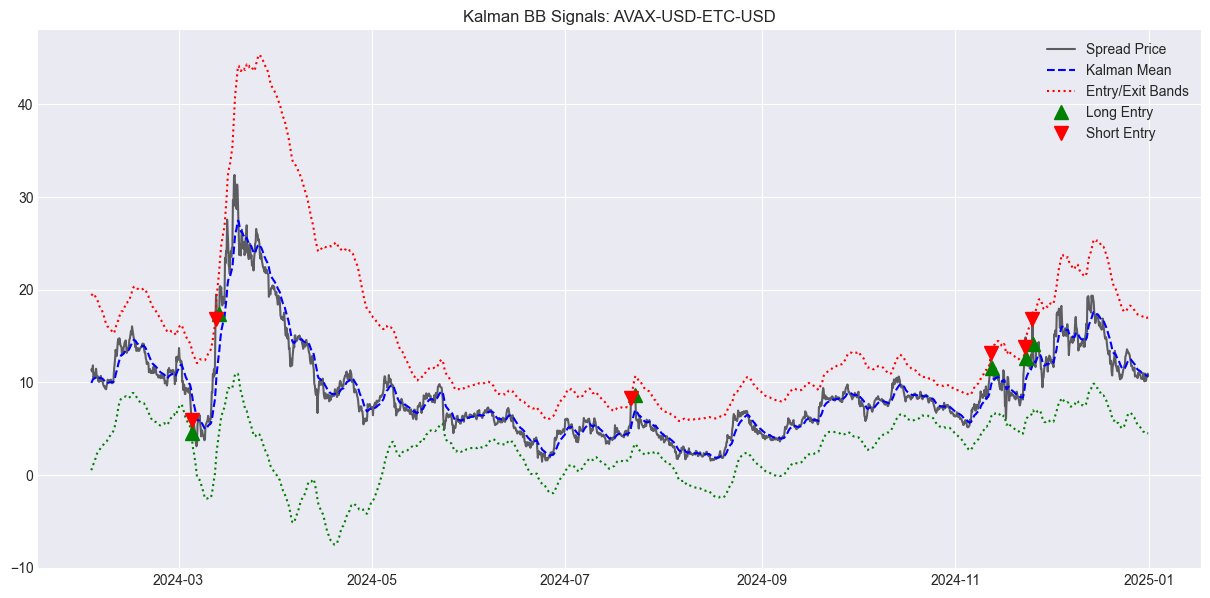

In [16]:
if not top5.empty:
    for _, row in top5.iterrows():
        pair_name = f"{row['Coin 1']}-{row['Coin 2']}"
        half_life = calculate_mean_reversion_half_life(row['Spread'])
        if half_life == np.inf or pd.isna(half_life):
            half_life = 120
        lookback = calculate_bollinger_bands_lookback(half_life)

        ema_equity = backtest_bb_strategy(row['Spread'], lookback)
        kalman_equity, kalman_signals, kalman_trade_count = backtest_kalman_bb_strategy(row['Spread'], lookback)

        ema_sharpe = calculate_sharpe_ratio(ema_equity)
        kalman_sharpe = calculate_sharpe_ratio(kalman_equity)

        print(f"{pair_name} EMA BB Sharpe: {ema_sharpe:.4f}, Kalman BB Sharpe: {kalman_sharpe:.4f}, Trades: {kalman_trade_count}")
        if not kalman_equity.empty:
            plt.figure(figsize=(15, 7))
            plt.plot(ema_equity, label=f'EMA BB (Sharpe: {ema_sharpe:.2f})')
            plt.plot(kalman_equity, label=f'Kalman BB (Sharpe: {kalman_sharpe:.2f})', linestyle='--')
            plt.title(f'Equity Curve Comparison: {pair_name}')
            plt.xlabel('Date')
            plt.ylabel('Cumulative PnL')
            plt.legend()
            plt.show()

            plt.figure(figsize=(15, 7))
            plt.plot(kalman_signals['price'], label='Spread Price', color='k', alpha=0.6)
            plt.plot(kalman_signals['middle_band'], label='Kalman Mean', color='b', linestyle='--')
            plt.plot(kalman_signals['upper_entry_band'], label='Entry/Exit Bands', color='r', linestyle=':')
            plt.plot(kalman_signals['lower_entry_band'], color='g', linestyle=':')
            buy_signals = kalman_signals[kalman_signals['position'] > kalman_signals['position'].shift(1)]
            sell_signals = kalman_signals[kalman_signals['position'] < kalman_signals['position'].shift(1)]
            plt.plot(buy_signals.index, buy_signals['price'], '^', markersize=10, color='g', label='Long Entry')
            plt.plot(sell_signals.index, sell_signals['price'], 'v', markersize=10, color='r', label='Short Entry')
            plt.title(f'Kalman BB Signals: {pair_name}')
            plt.legend()
            plt.show()
